In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

## Load data and make compatible

In [2]:
# load Zambia shapefiles
zambia = 'Data/district.shp'

# read shapefile into geodataframe
gdf = gpd.read_file(zambia)

print(gdf.head())

ERROR 1: PROJ: proj_create_from_database: Open of /mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/share/proj failed


       GID_2 GID_0 COUNTRY    GID_1   NAME_1 NL_NAME_1        NAME_2  \
0  ZMB.1.1_2   ZMB  Zambia  ZMB.1_1  Central        NA      Chibombo   
1  ZMB.1.2_2   ZMB  Zambia  ZMB.1_1  Central        NA      Chisamba   
2  ZMB.1.3_2   ZMB  Zambia  ZMB.1_1  Central        NA      Chitambo   
3  ZMB.1.4_2   ZMB  Zambia  ZMB.1_1  Central        NA  Itezhi-tezhi   
4  ZMB.1.5_2   ZMB  Zambia  ZMB.1_1  Central        NA         Kabwe   

  VARNAME_2 NL_NAME_2    TYPE_2 ENGTYPE_2 CC_2 HASC_2  \
0        NA        NA  District  District   NA     NA   
1        NA        NA  District  District   NA     NA   
2        NA        NA  District  District   NA     NA   
3        NA        NA  District  District   NA     NA   
4        NA        NA  District  District   NA     NA   

                                            geometry  
0  POLYGON ((28.00409 -14.51361, 28.00989 -14.514...  
1  POLYGON ((28.36680 -15.16628, 28.36061 -15.162...  
2  POLYGON ((29.81841 -12.98202, 29.82574 -12.495...  
3  P

In [3]:
# load district-level SPEI data
spei_df = pd.read_csv('district_spei_average.csv')

# remove spatial_ref column
spei_df_clean = spei_df.drop(columns='spatial_ref')

# convert to long format
spei_long = spei_df_clean.melt(
    id_vars = 'date',
    var_name = 'district',
    value_name = 'spei'
)

# convert to datetime and extract year
spei_long['date'] = pd.to_datetime(spei_long['date'])
spei_long['year'] = spei_long['date'].dt.year

# aggregate SPEI to annual mean
spei_annual = spei_long.groupby(['district', 'year'])['spei'].mean().reset_index()

# export to csv
spei_annual.to_csv('district_spei_annual.csv', index=False)

In [4]:
# load growing period data
growing_period_df = pd.read_csv('district_growing_periods.csv')
growing_period_df.head()

,district,year,mean_growing_period
0,Chibombo,2000,173.409091
1,Chisamba,2000,173.619048
2,Chitambo,2000,178.753521
3,Itezhi-tezhi,2000,161.838384
4,Kabwe,2000,174.444444


In [5]:
# merge spei and growing season dataframes
combined_df = pd.merge(spei_annual, growing_period_df, on=['district', 'year'], how='inner')

combined_df.to_csv('spei_mean_growing_season.csv')

## Bin districts into provinces

In [6]:
# create district - province lookup
district_to_province = gdf[['NAME_2', 'NAME_1']].drop_duplicates()
district_to_province.columns = ['district', 'province']

# merge with SPEI/growing period data
growing_df = pd.read_csv('spei_mean_growing_season.csv')

# merge province info
merged = pd.merge(growing_df, district_to_province, on='district', how='left')

# inspect
merged.head()

merged.to_csv('district_province_spei_growingperiod.csv')

In [7]:
df = pd.read_csv('district_province_spei_growingperiod.csv')

In [9]:
df.head()

,Unnamed: 0.1,Unnamed: 0,district,year,spei,mean_growing_period,province
0,0,0,Chadiza,2000,0.680755,194.2500,Eastern
1,1,1,Chadiza,2001,0.716411,162.7500,Eastern
2,2,2,Chadiza,2002,0.360377,173.3125,Eastern
3,3,3,Chadiza,2003,0.234326,154.3125,Eastern
4,4,4,Chadiza,2004,0.169925,193.1875,Eastern


## Plot

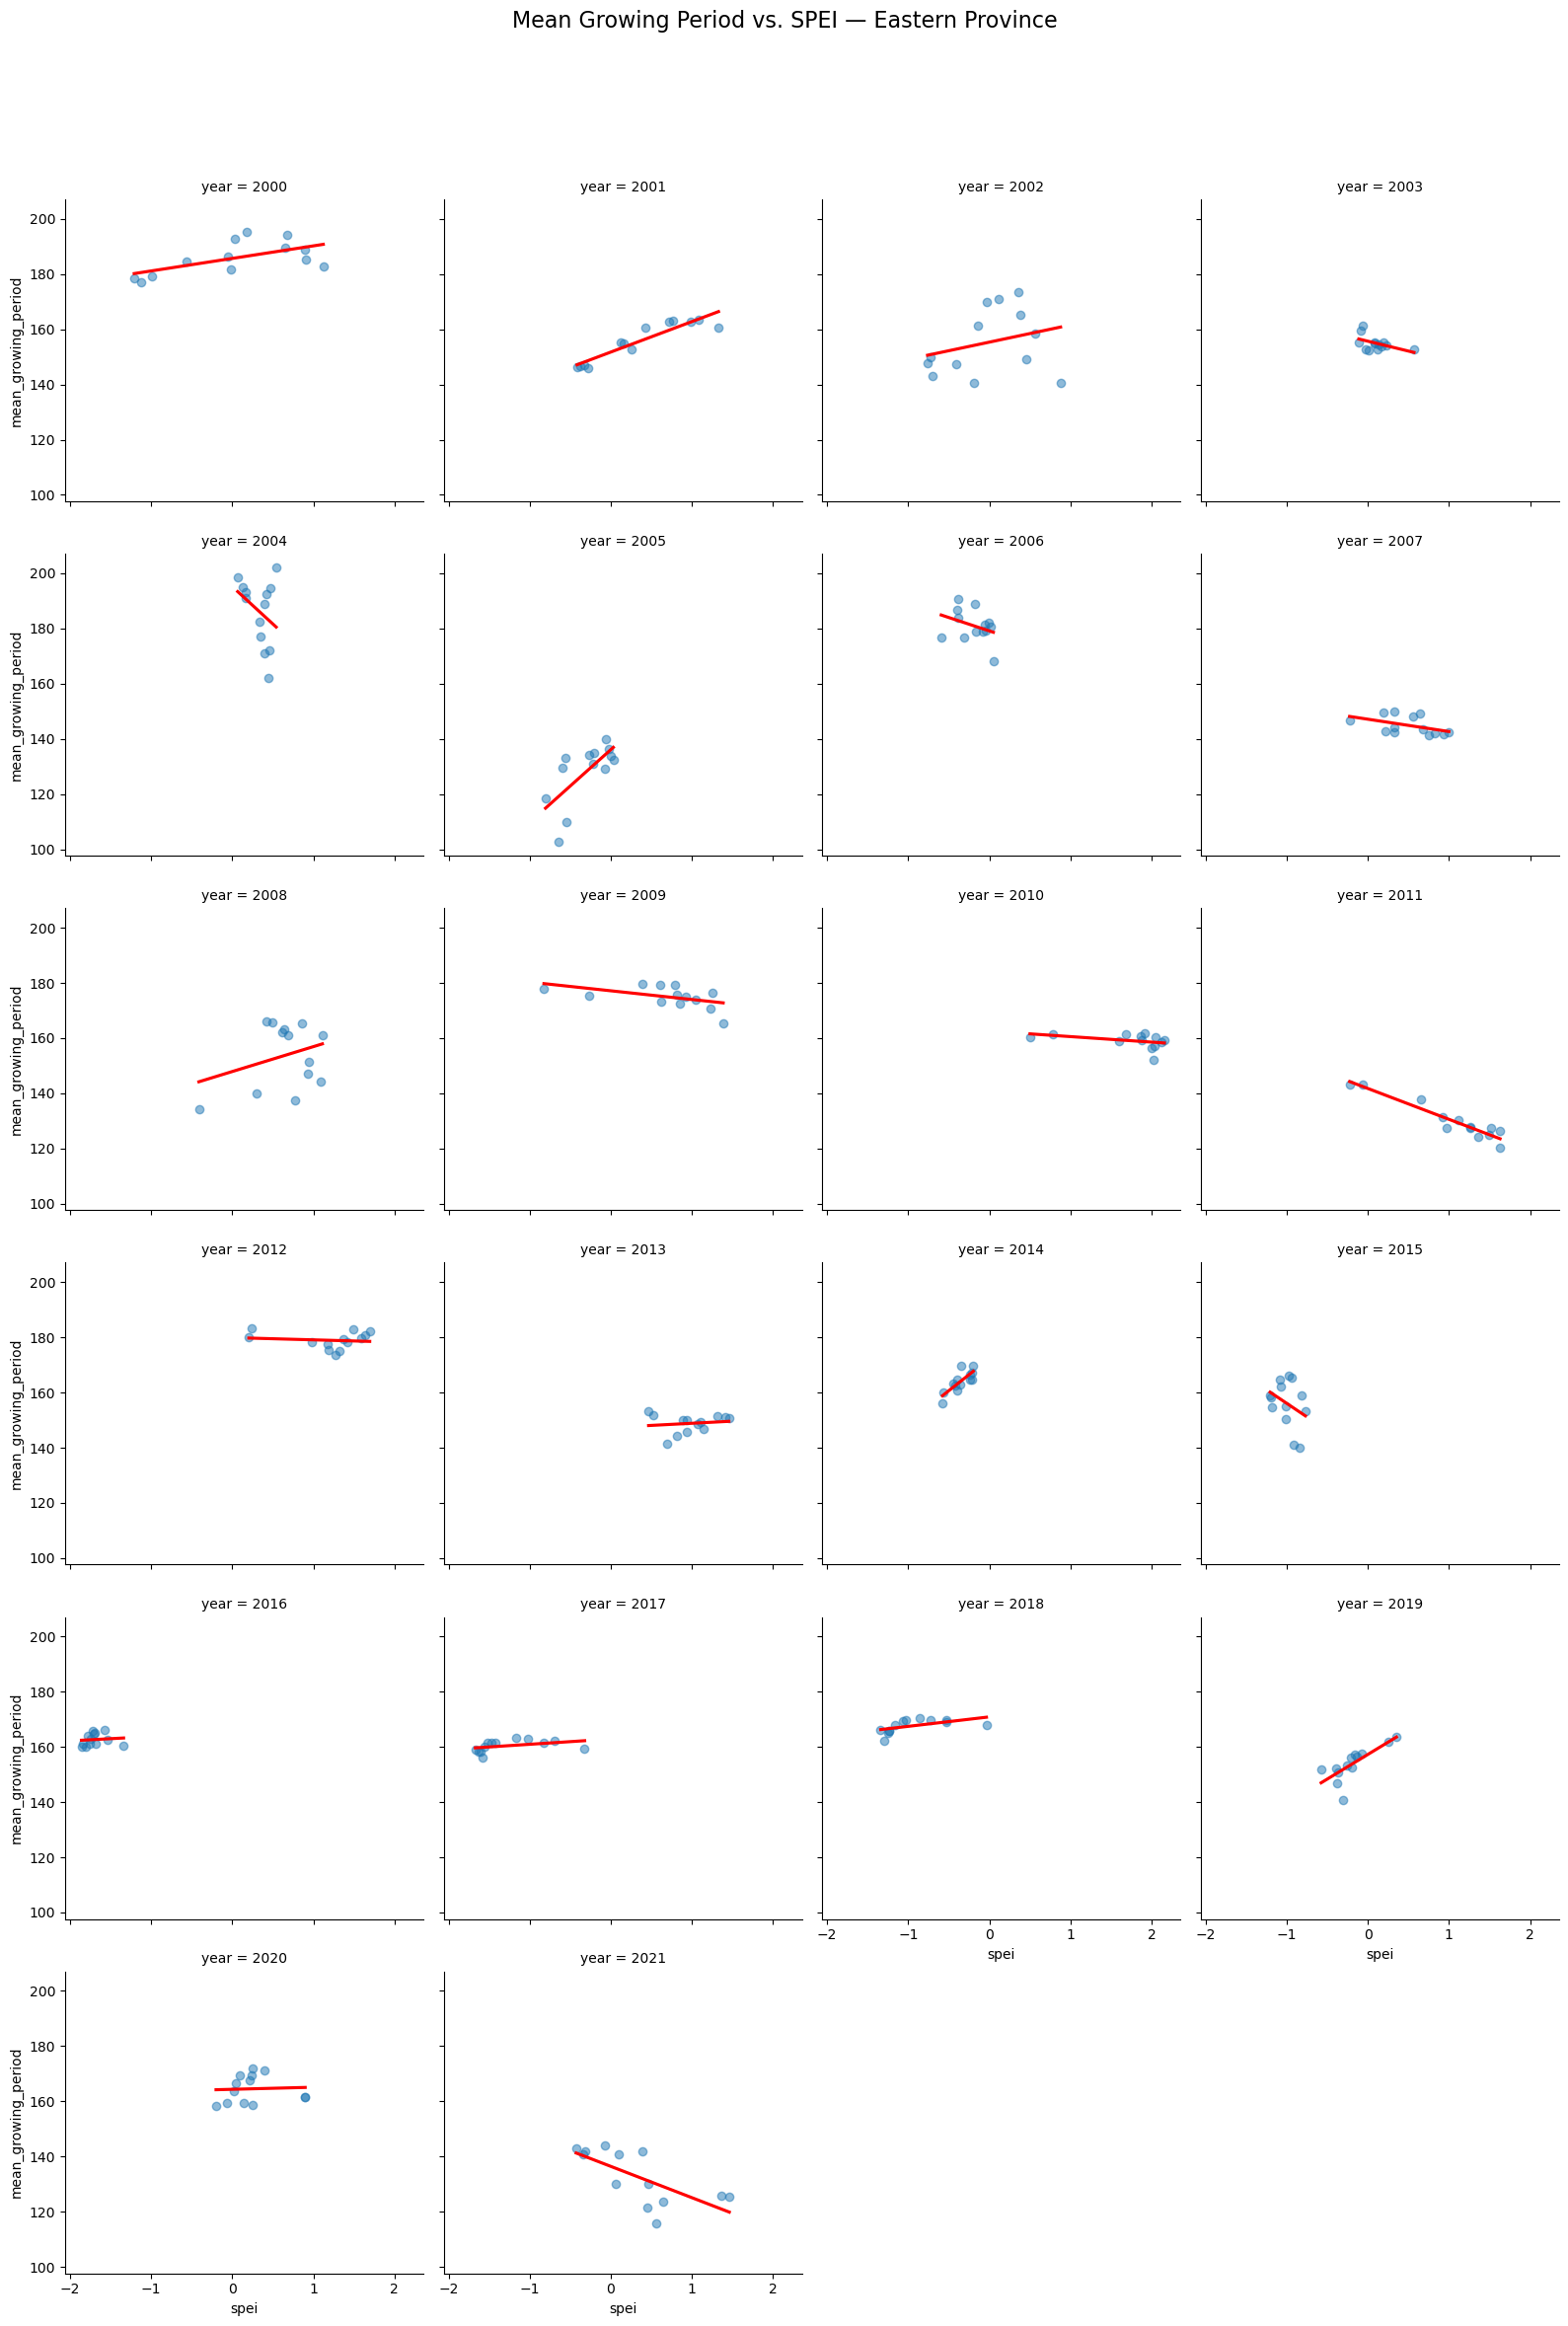

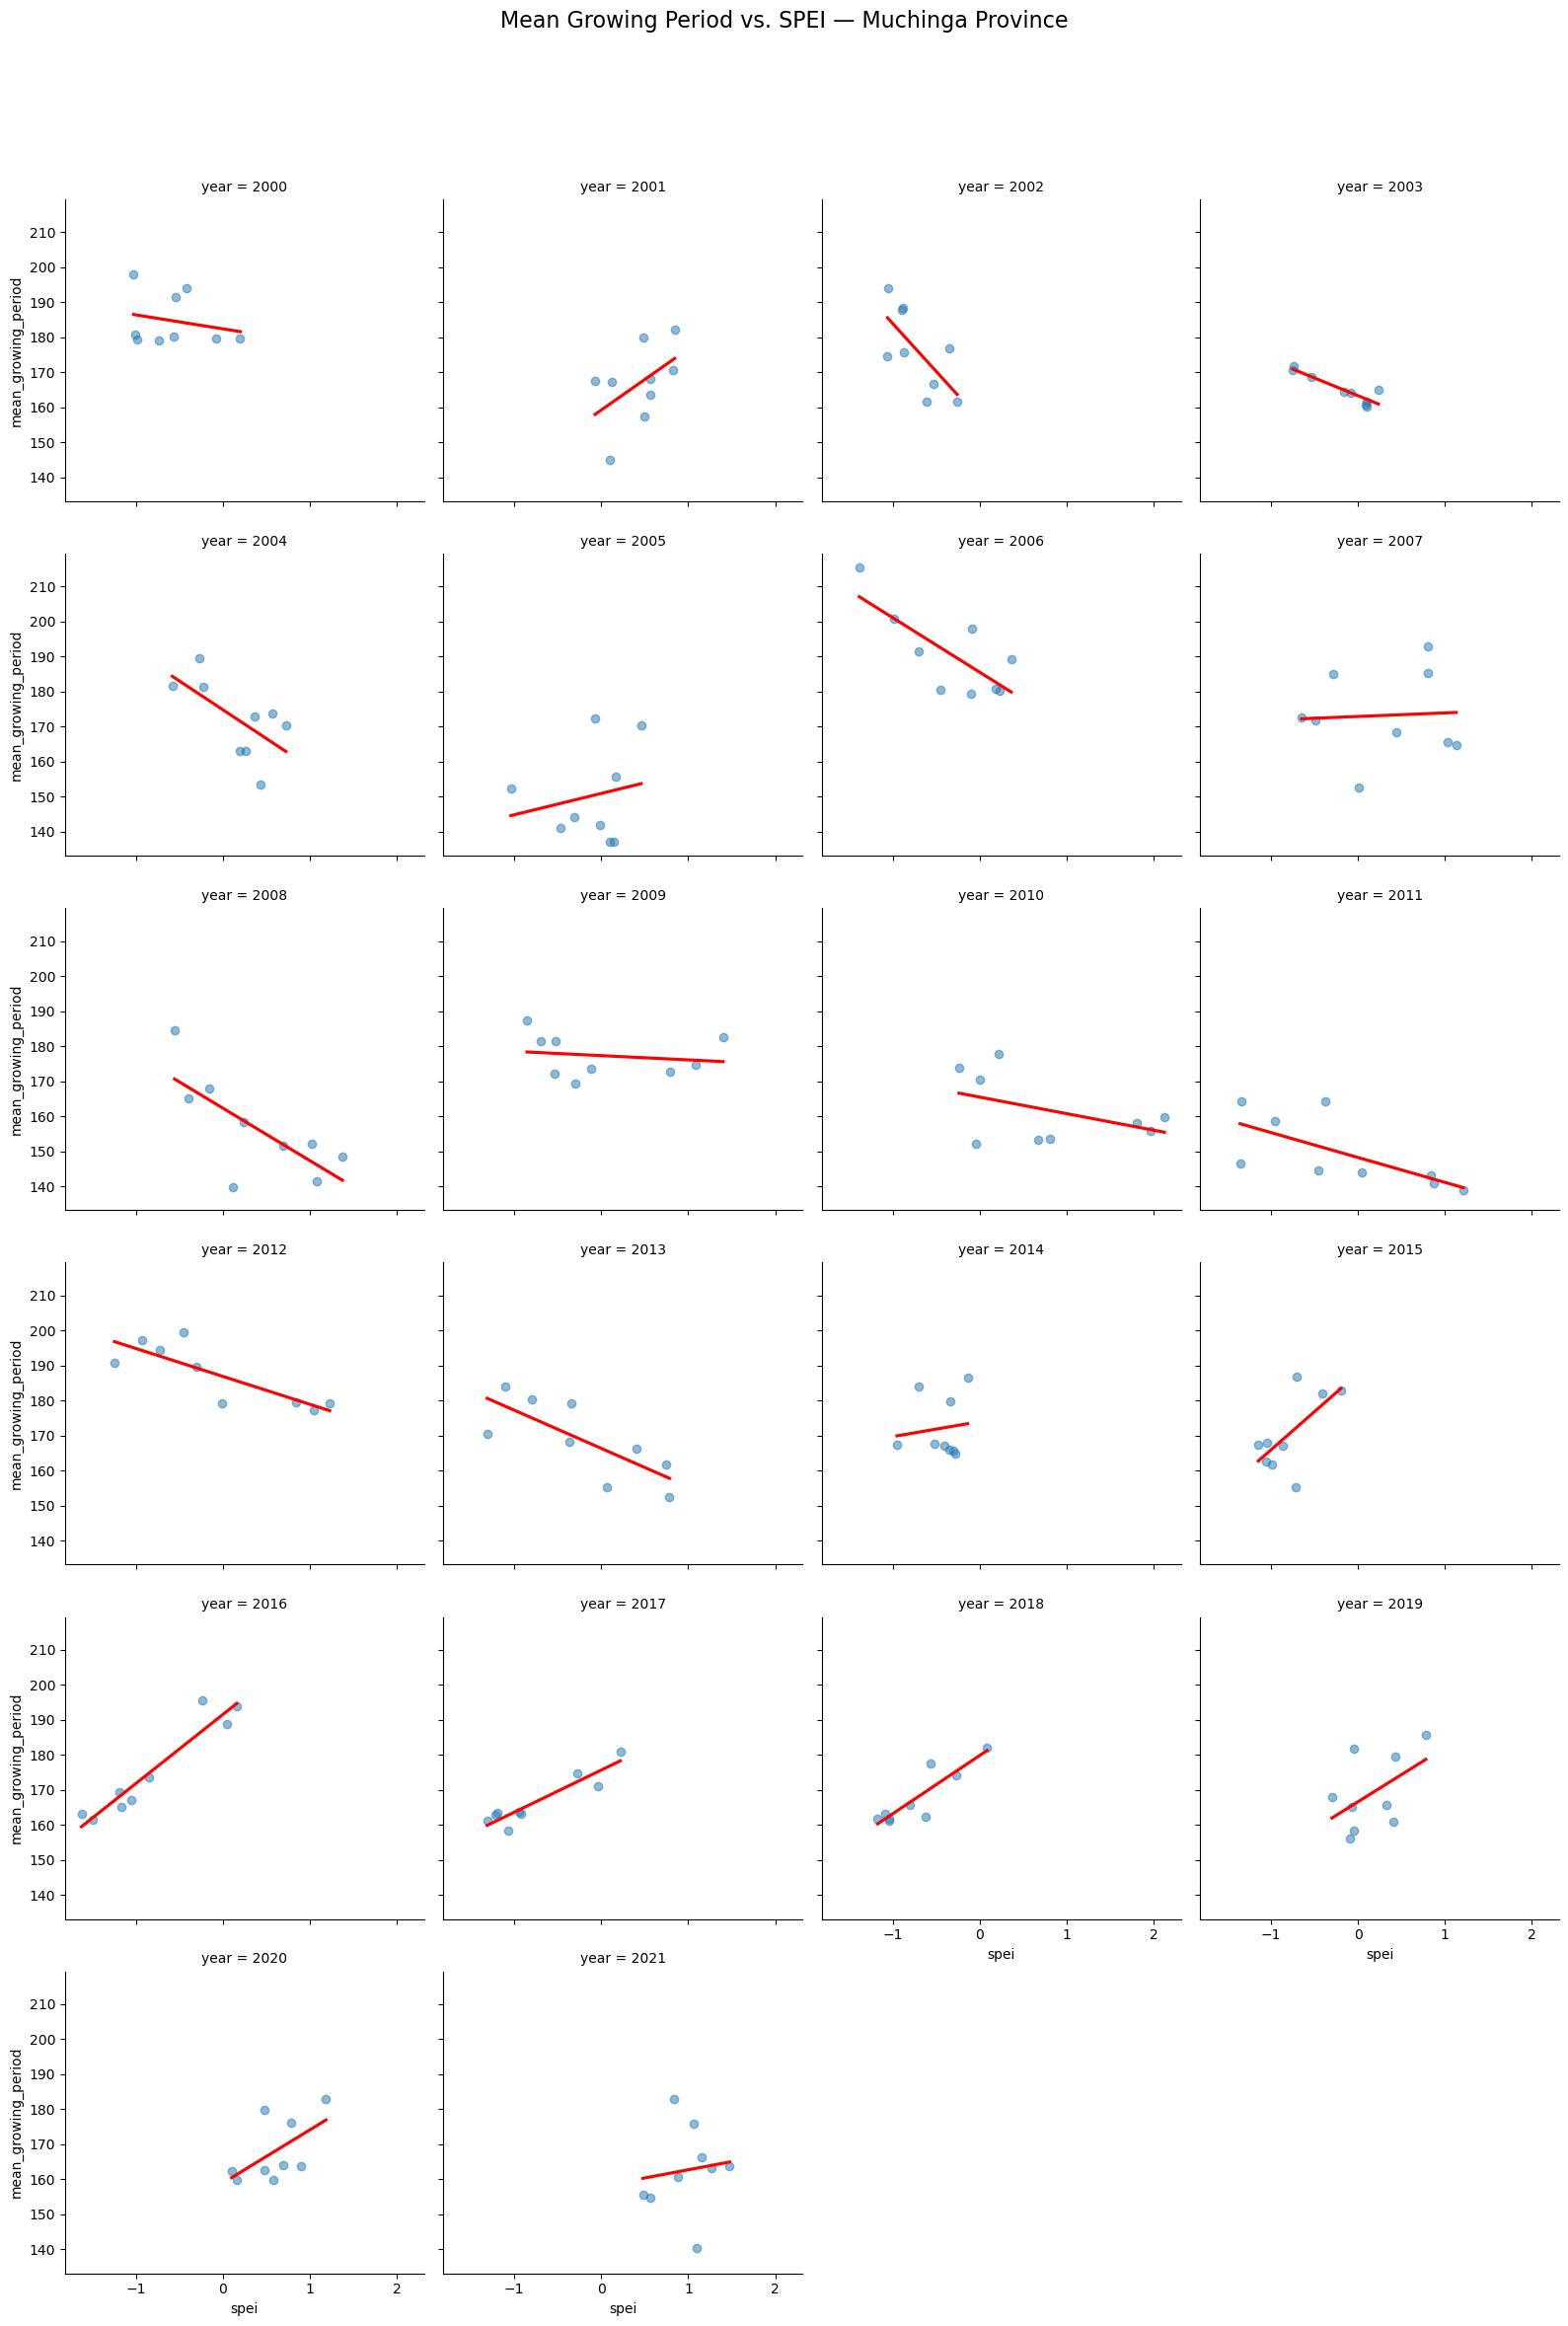

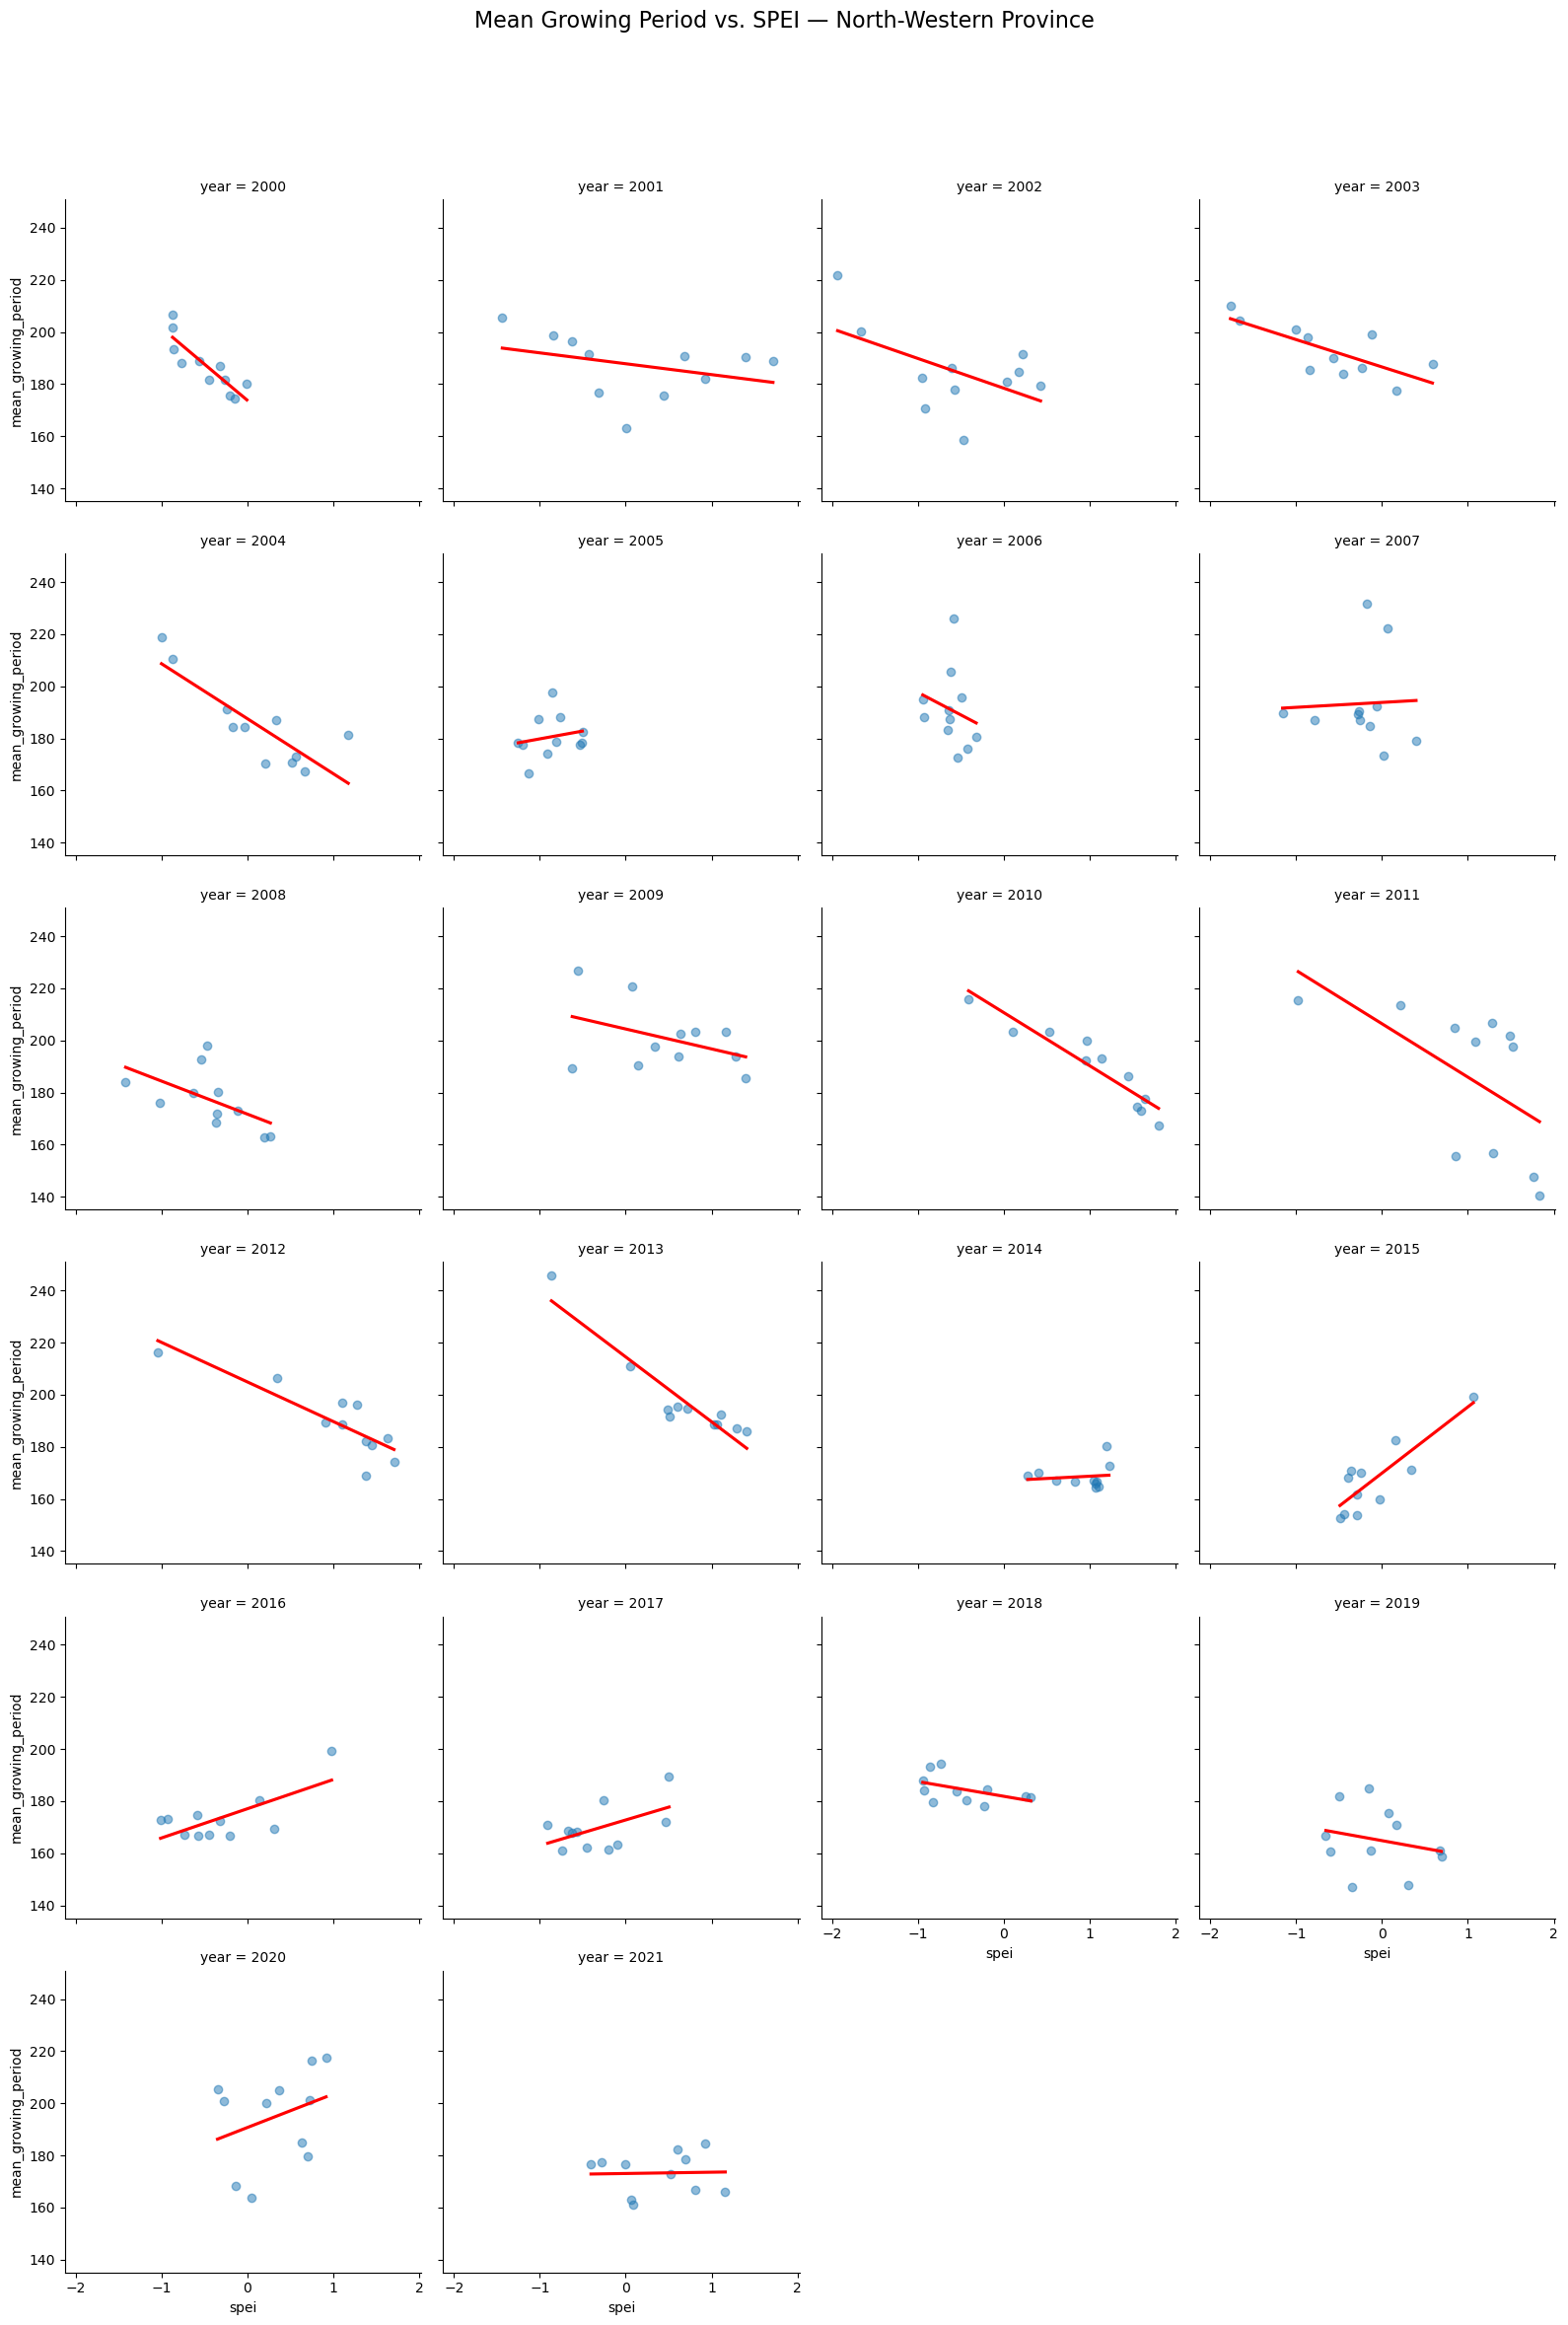

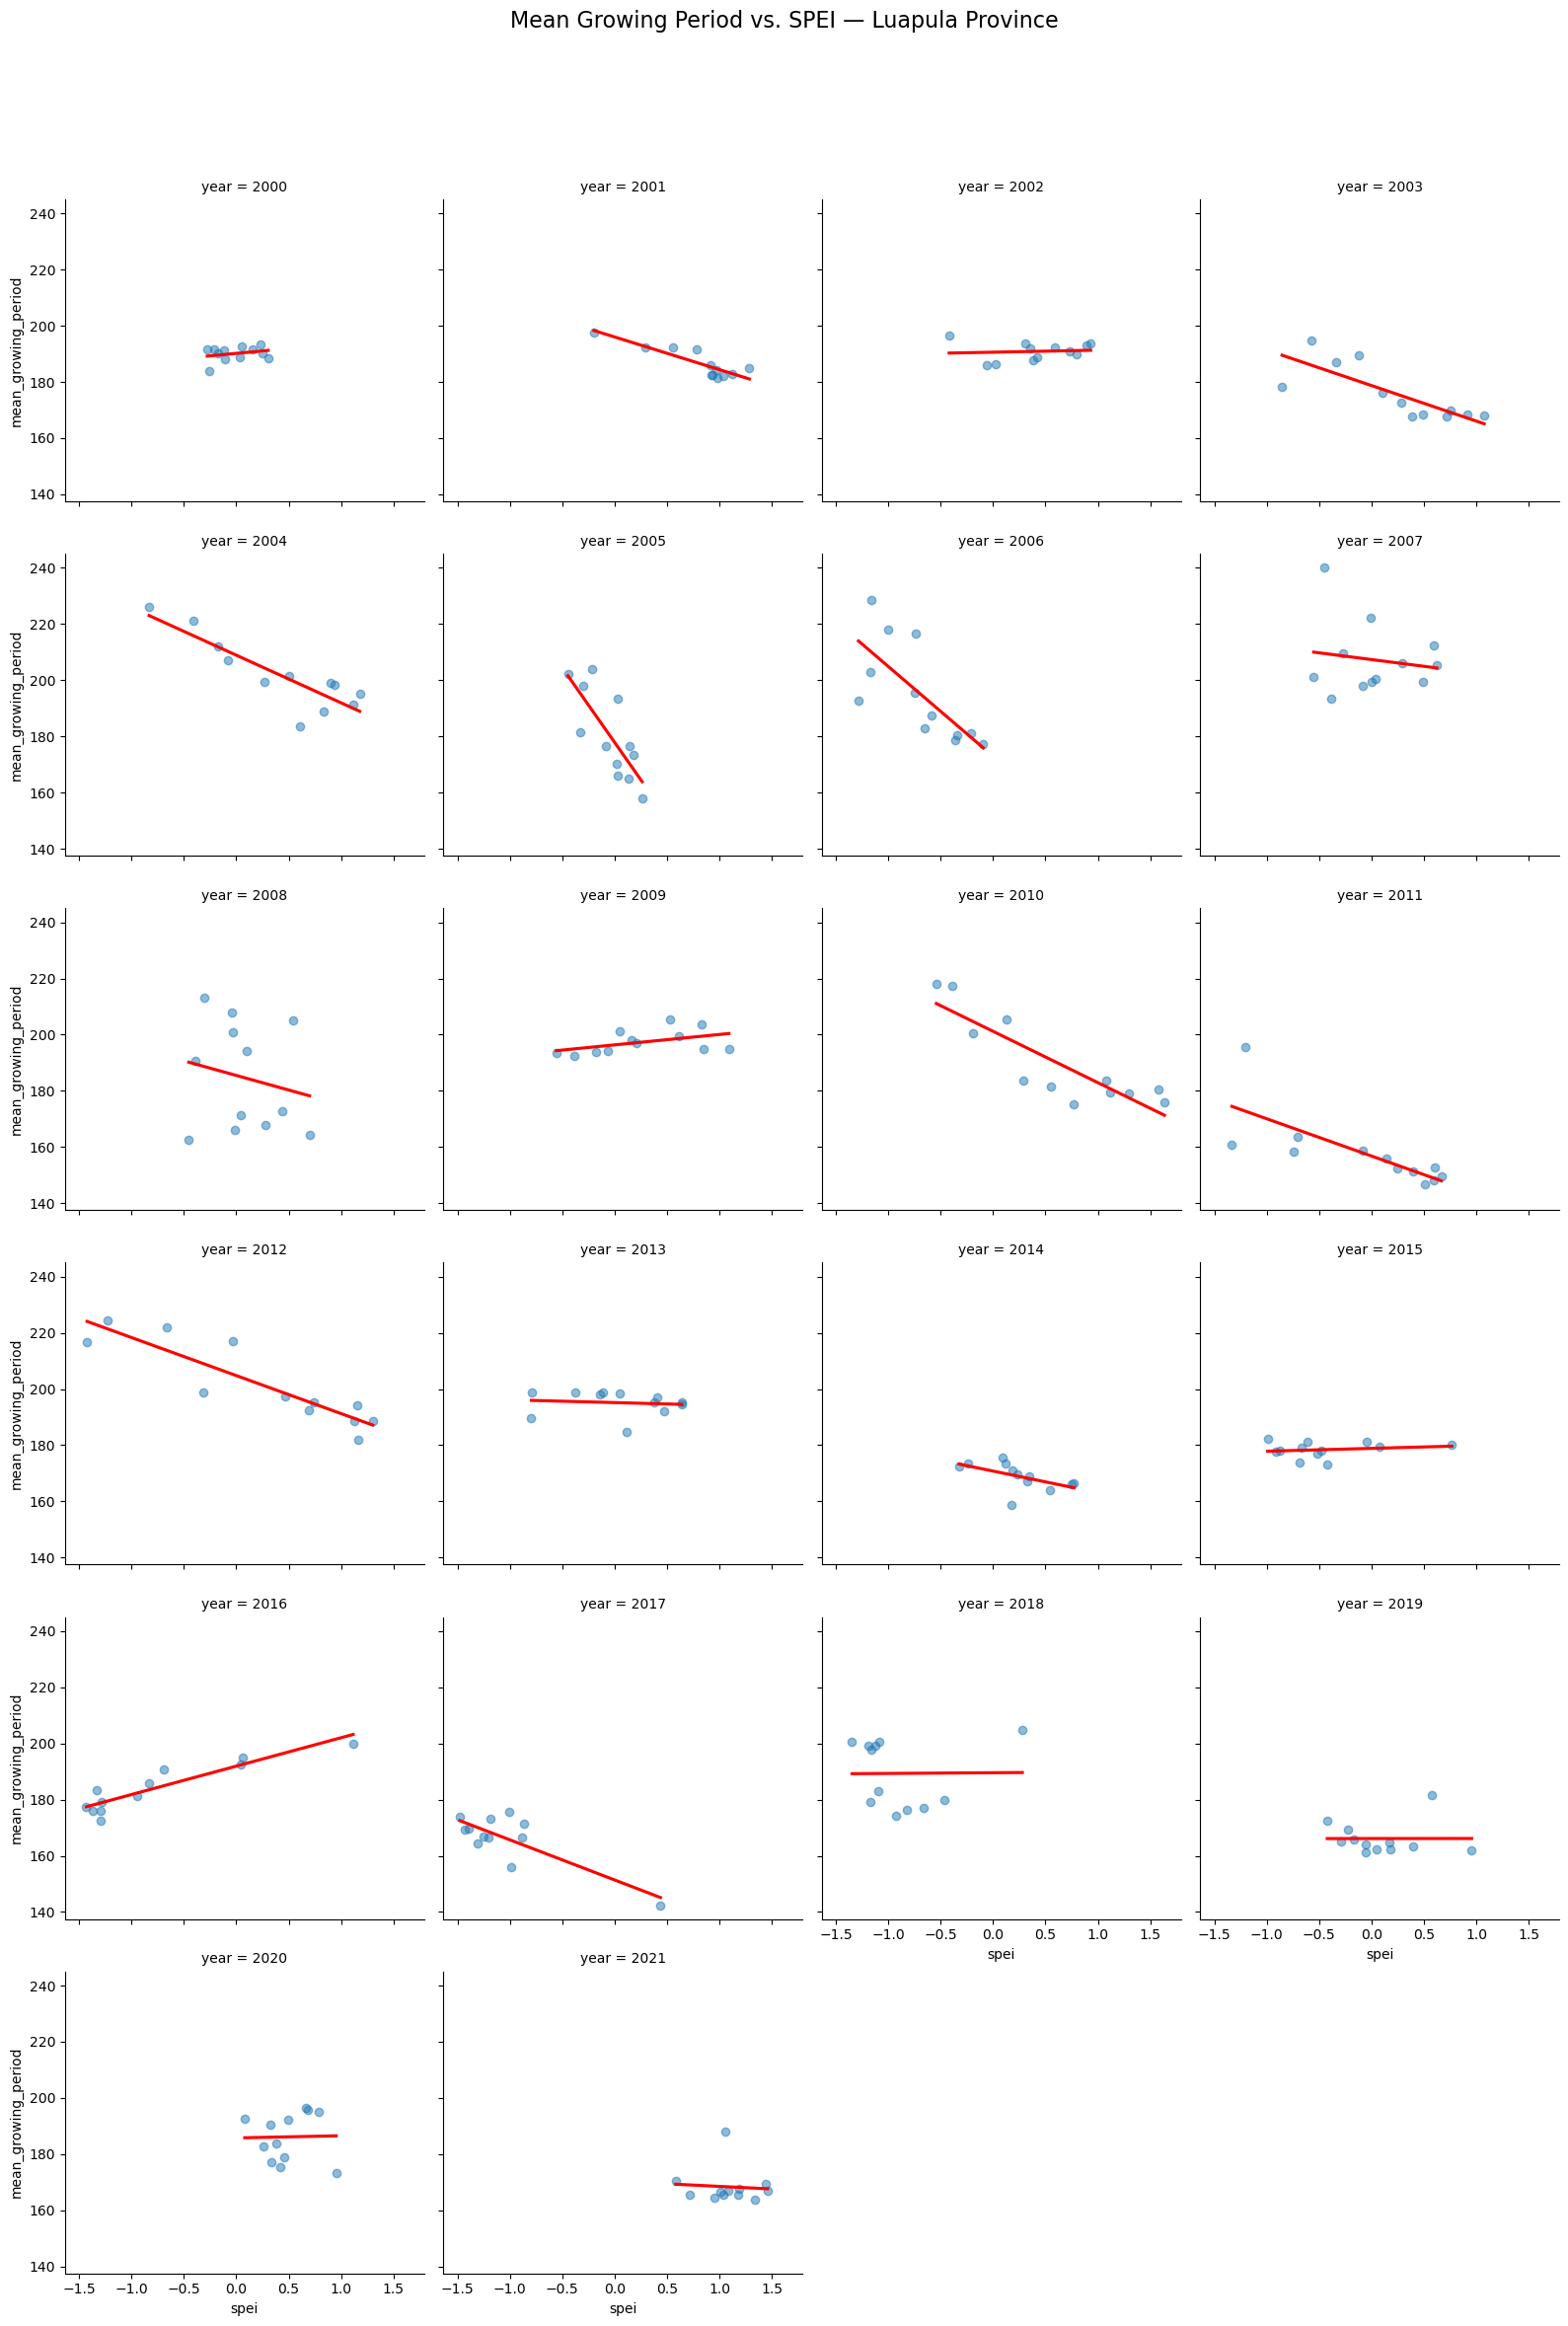

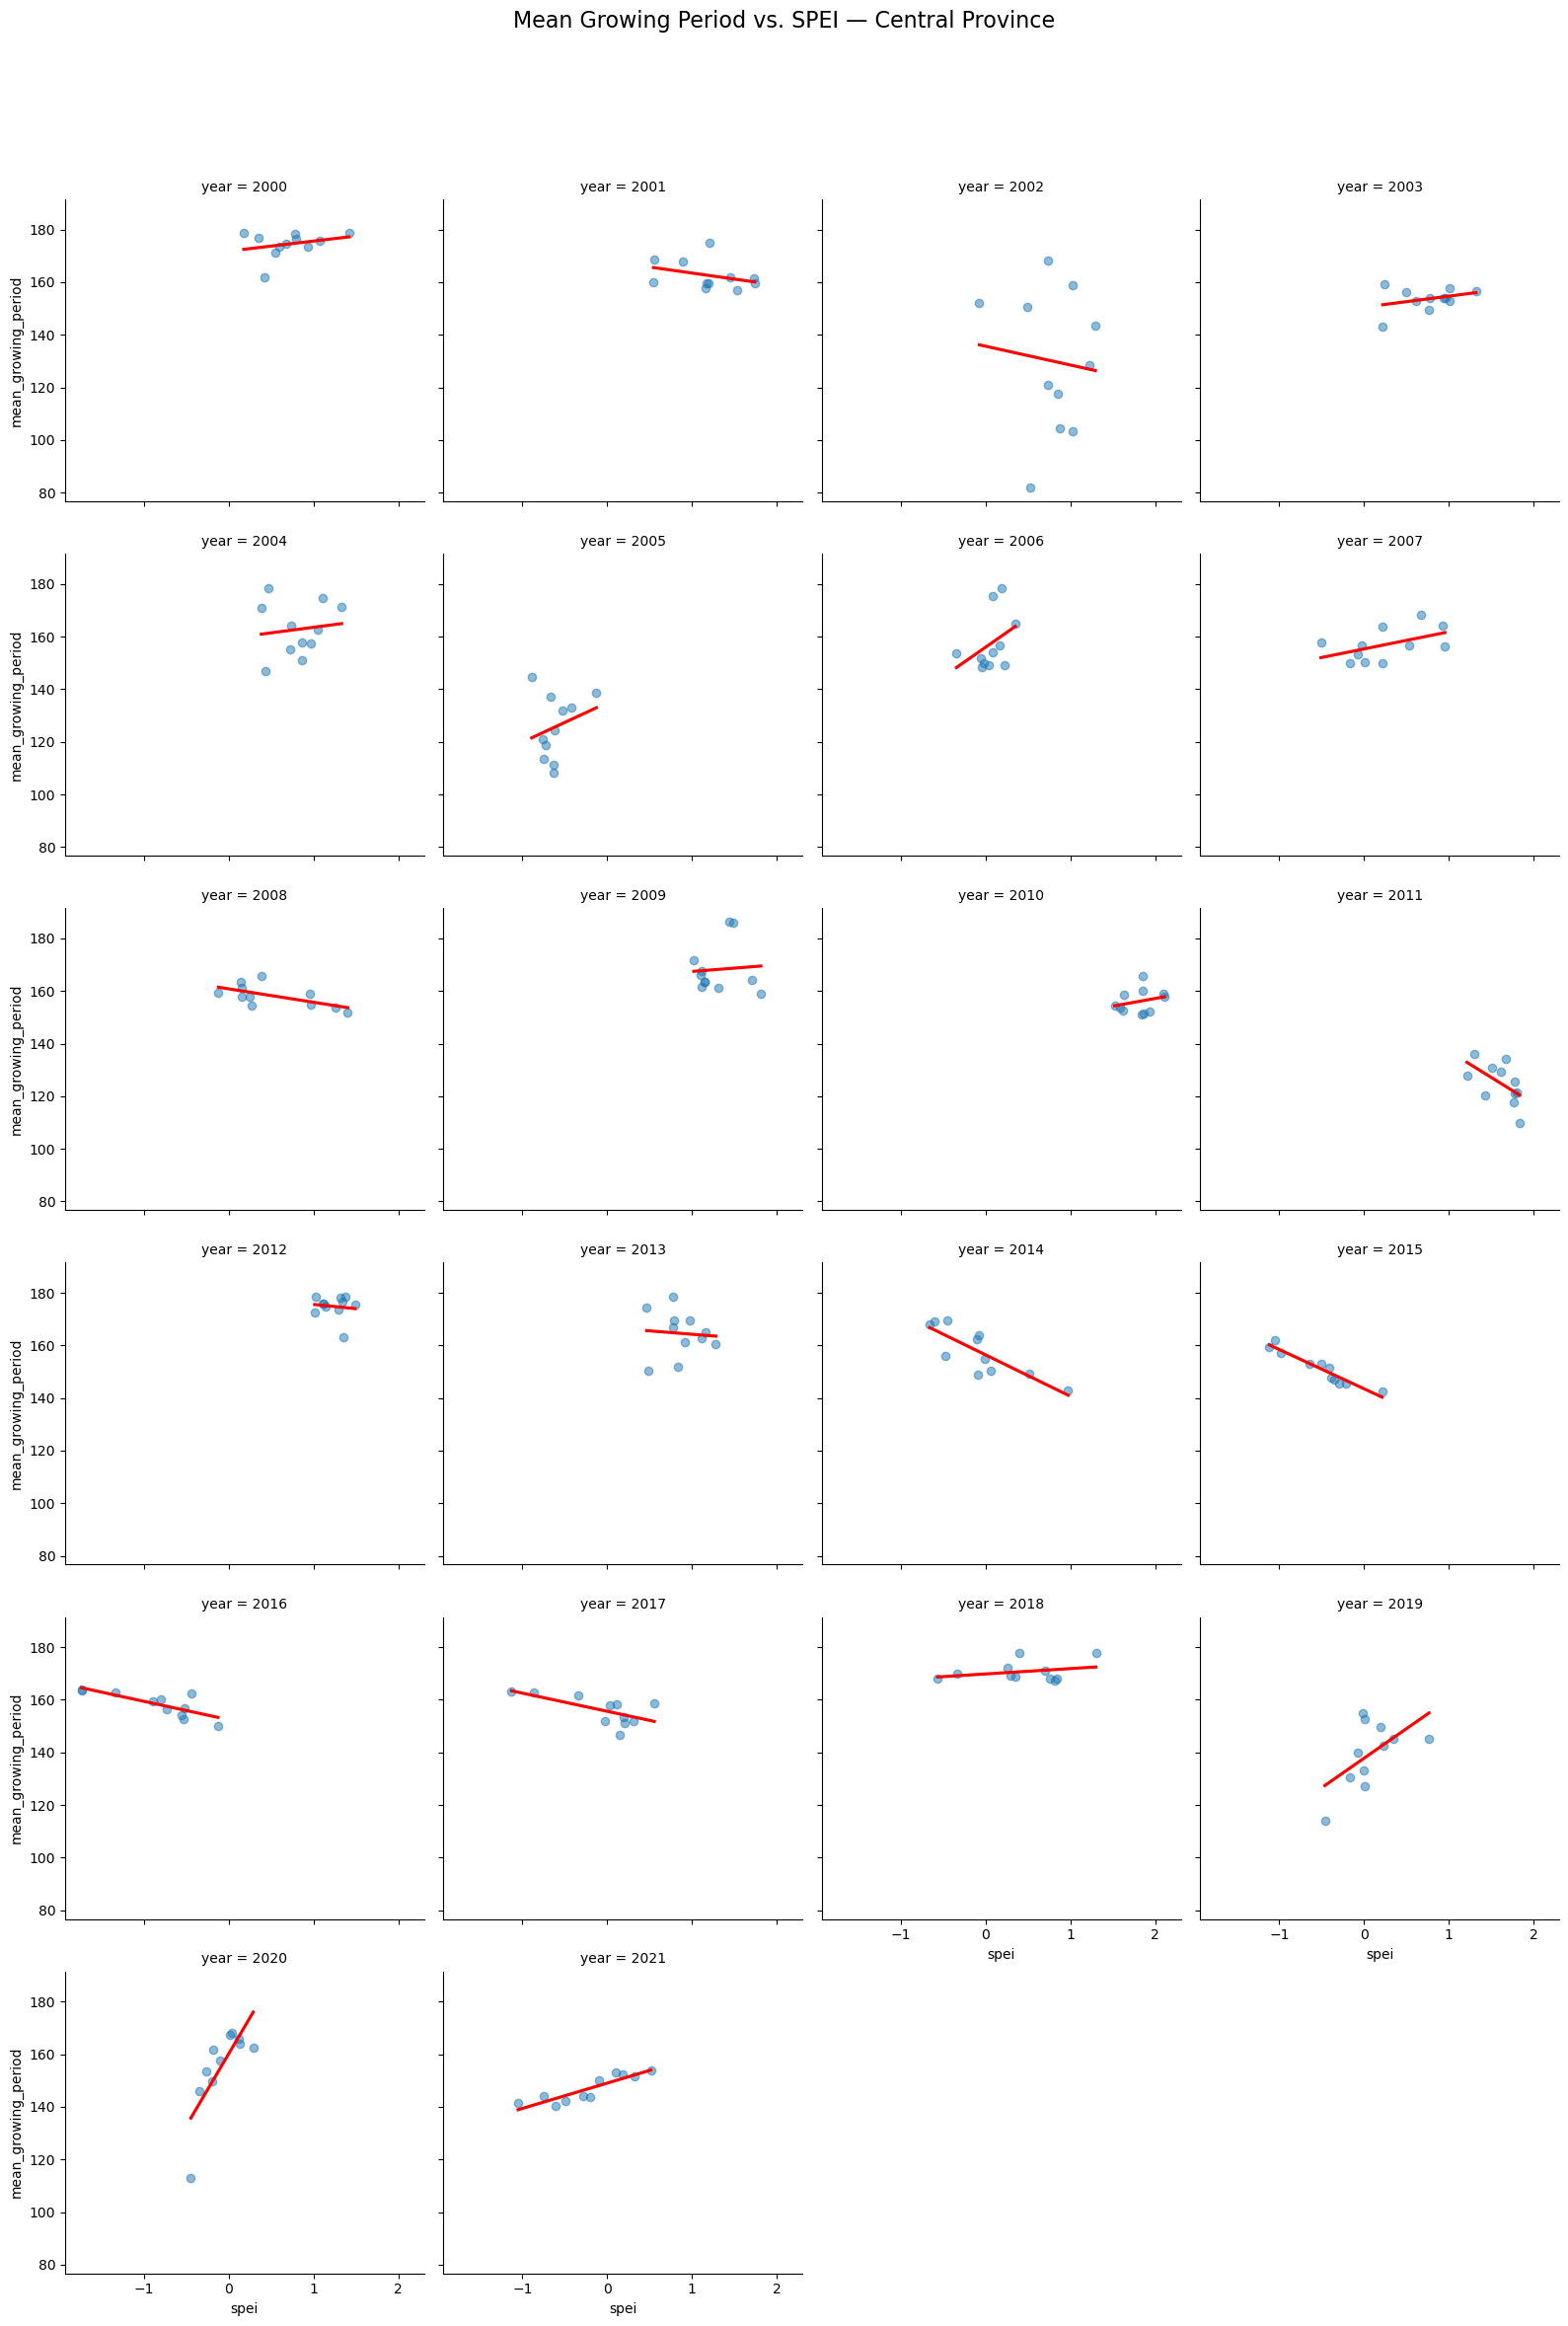

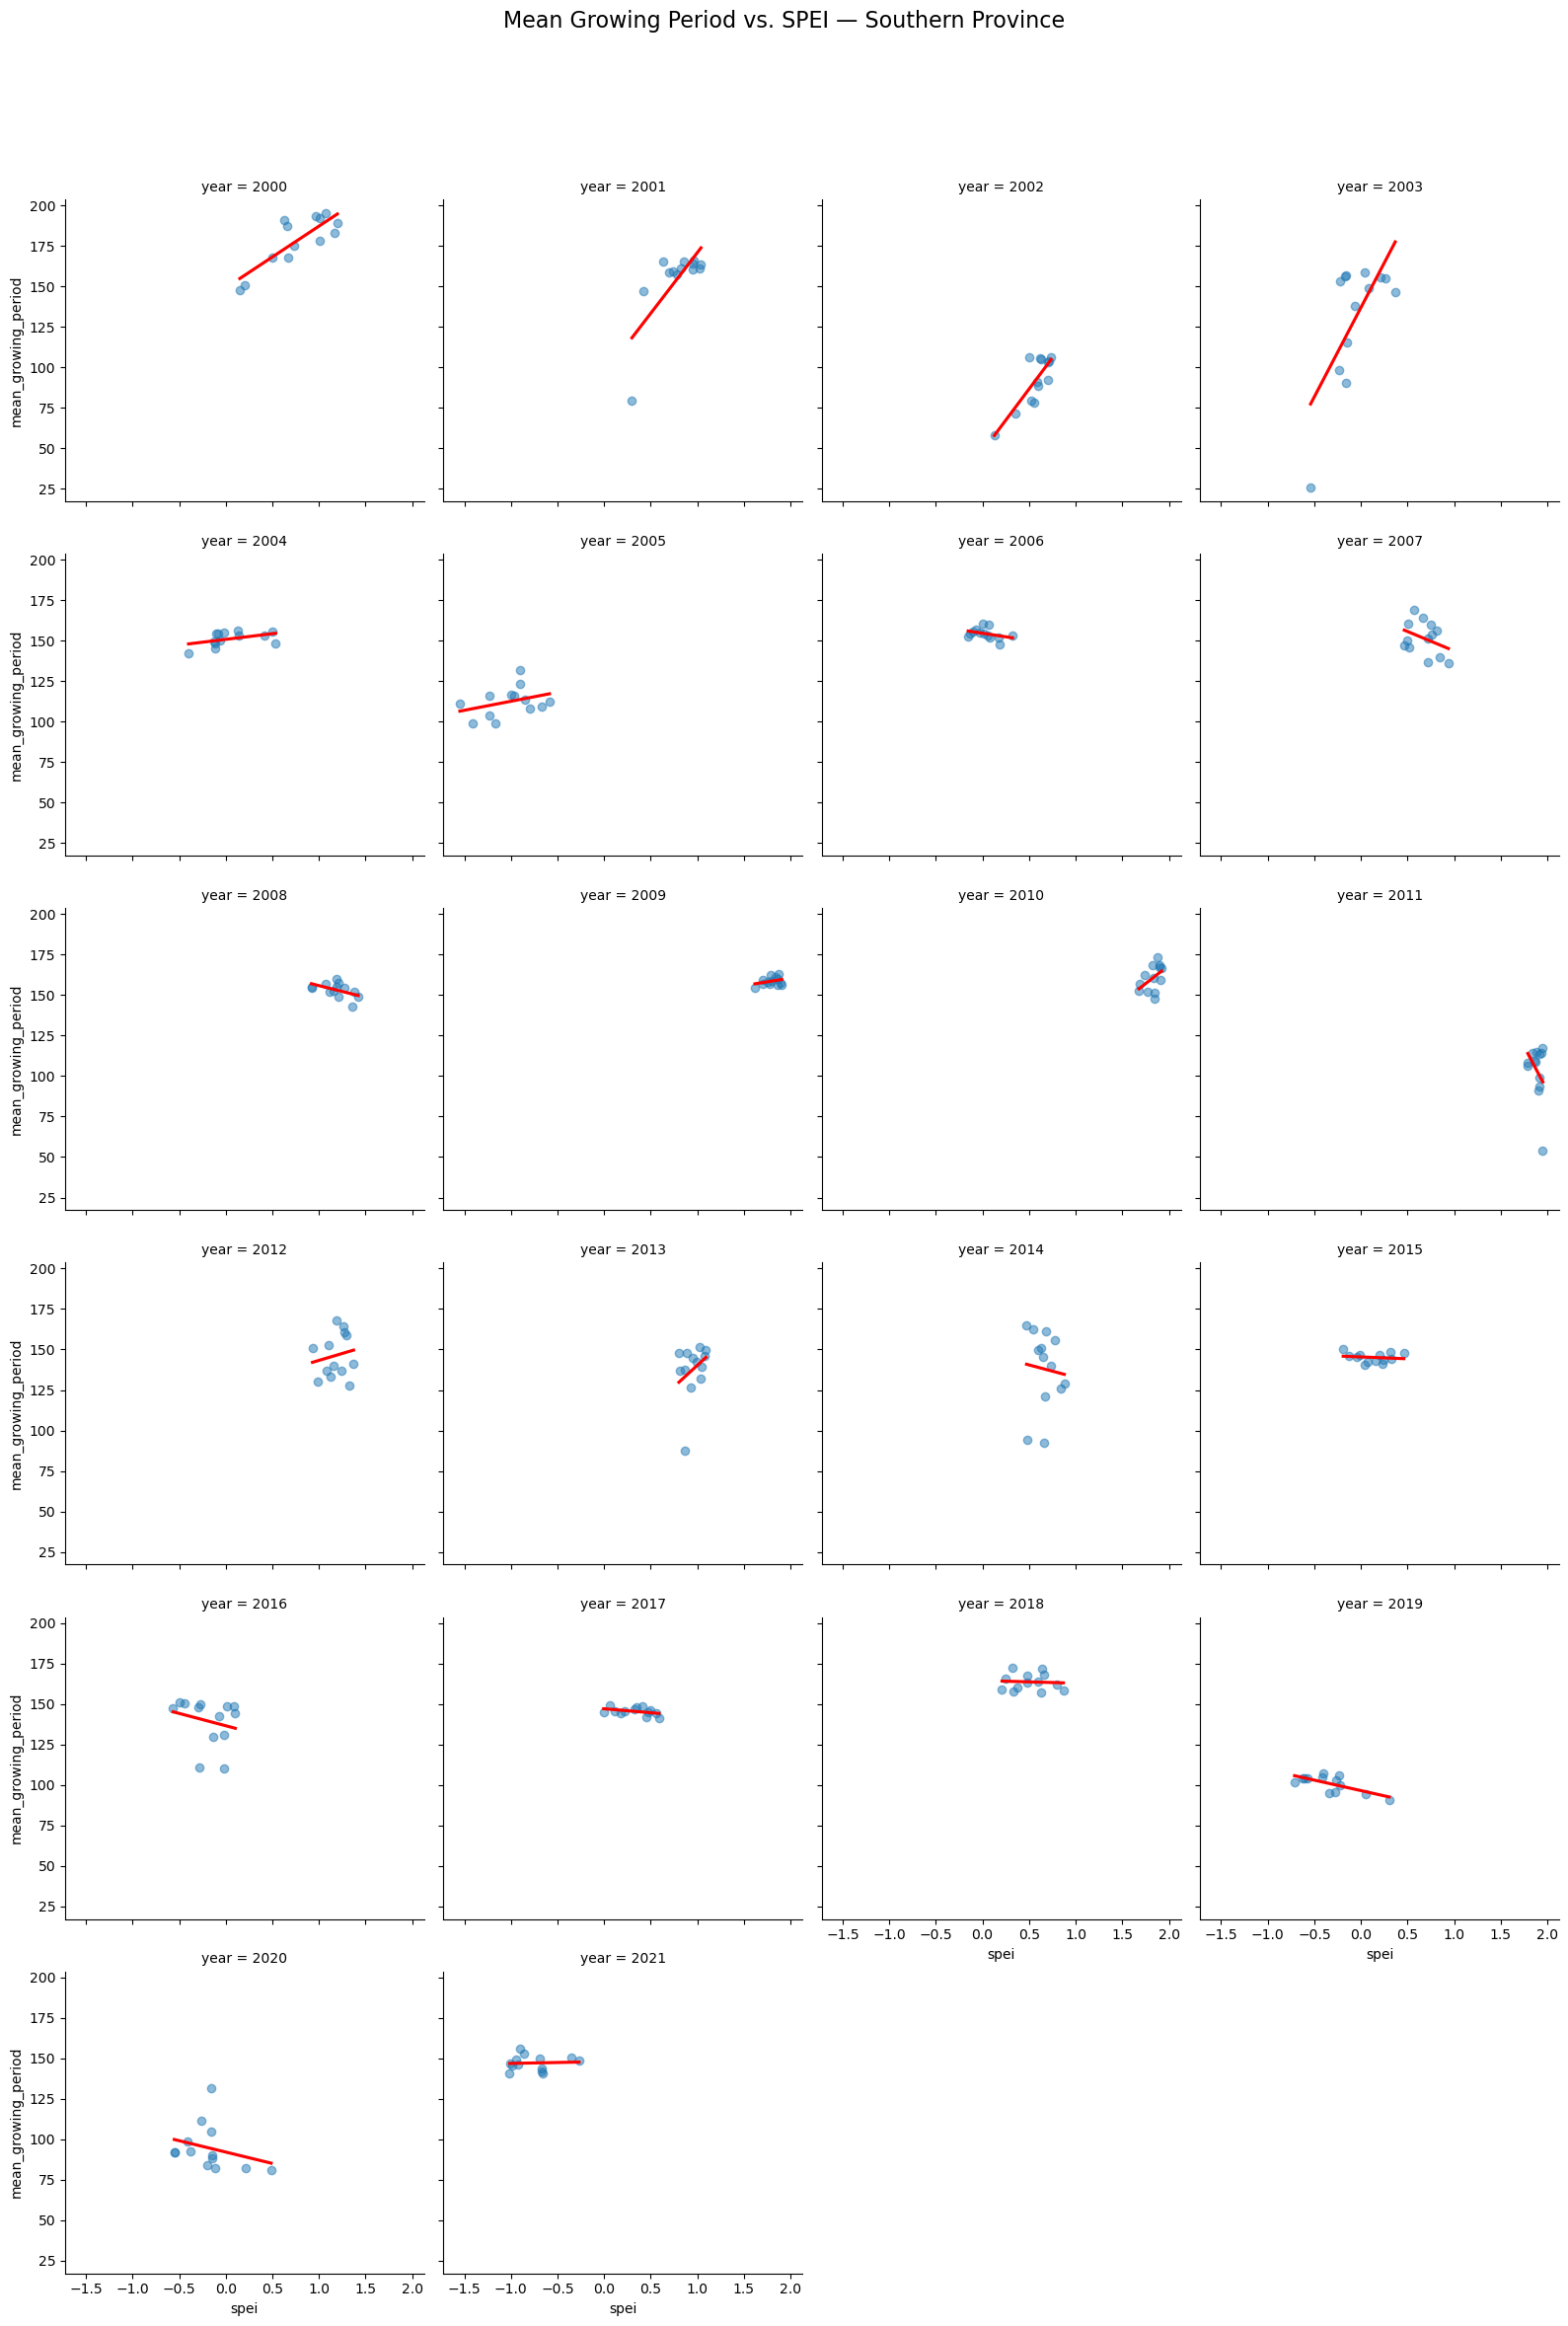

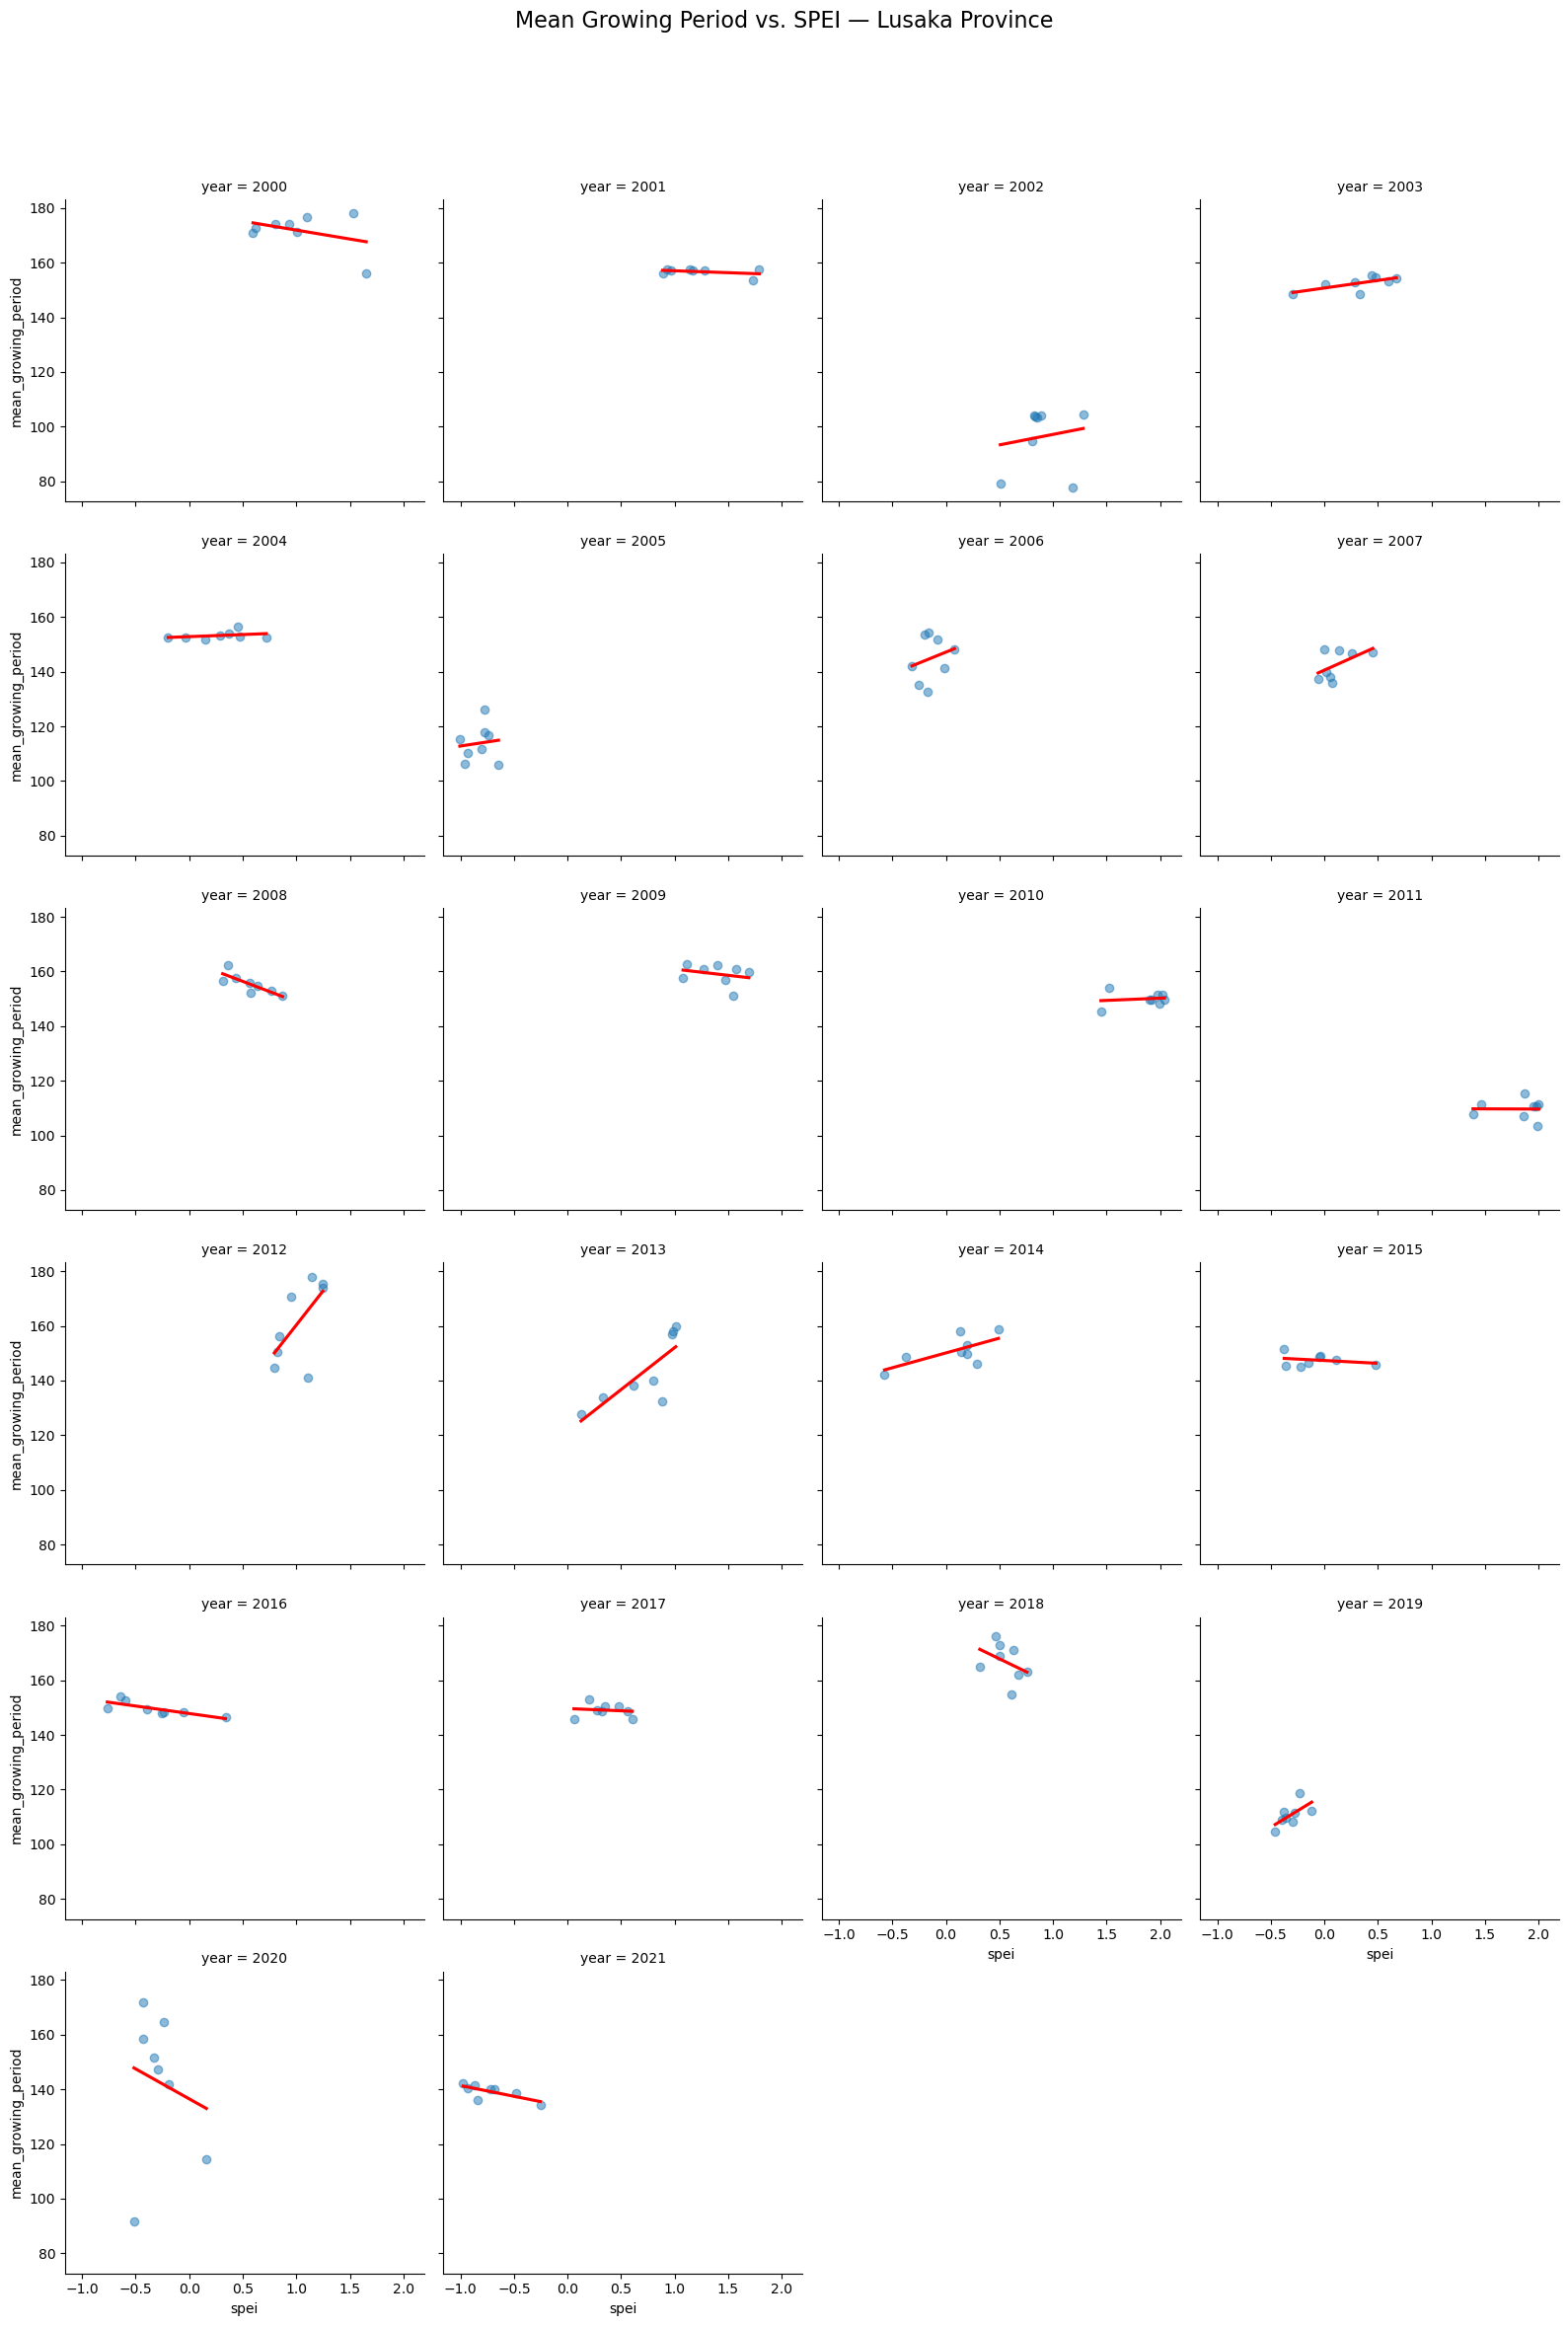

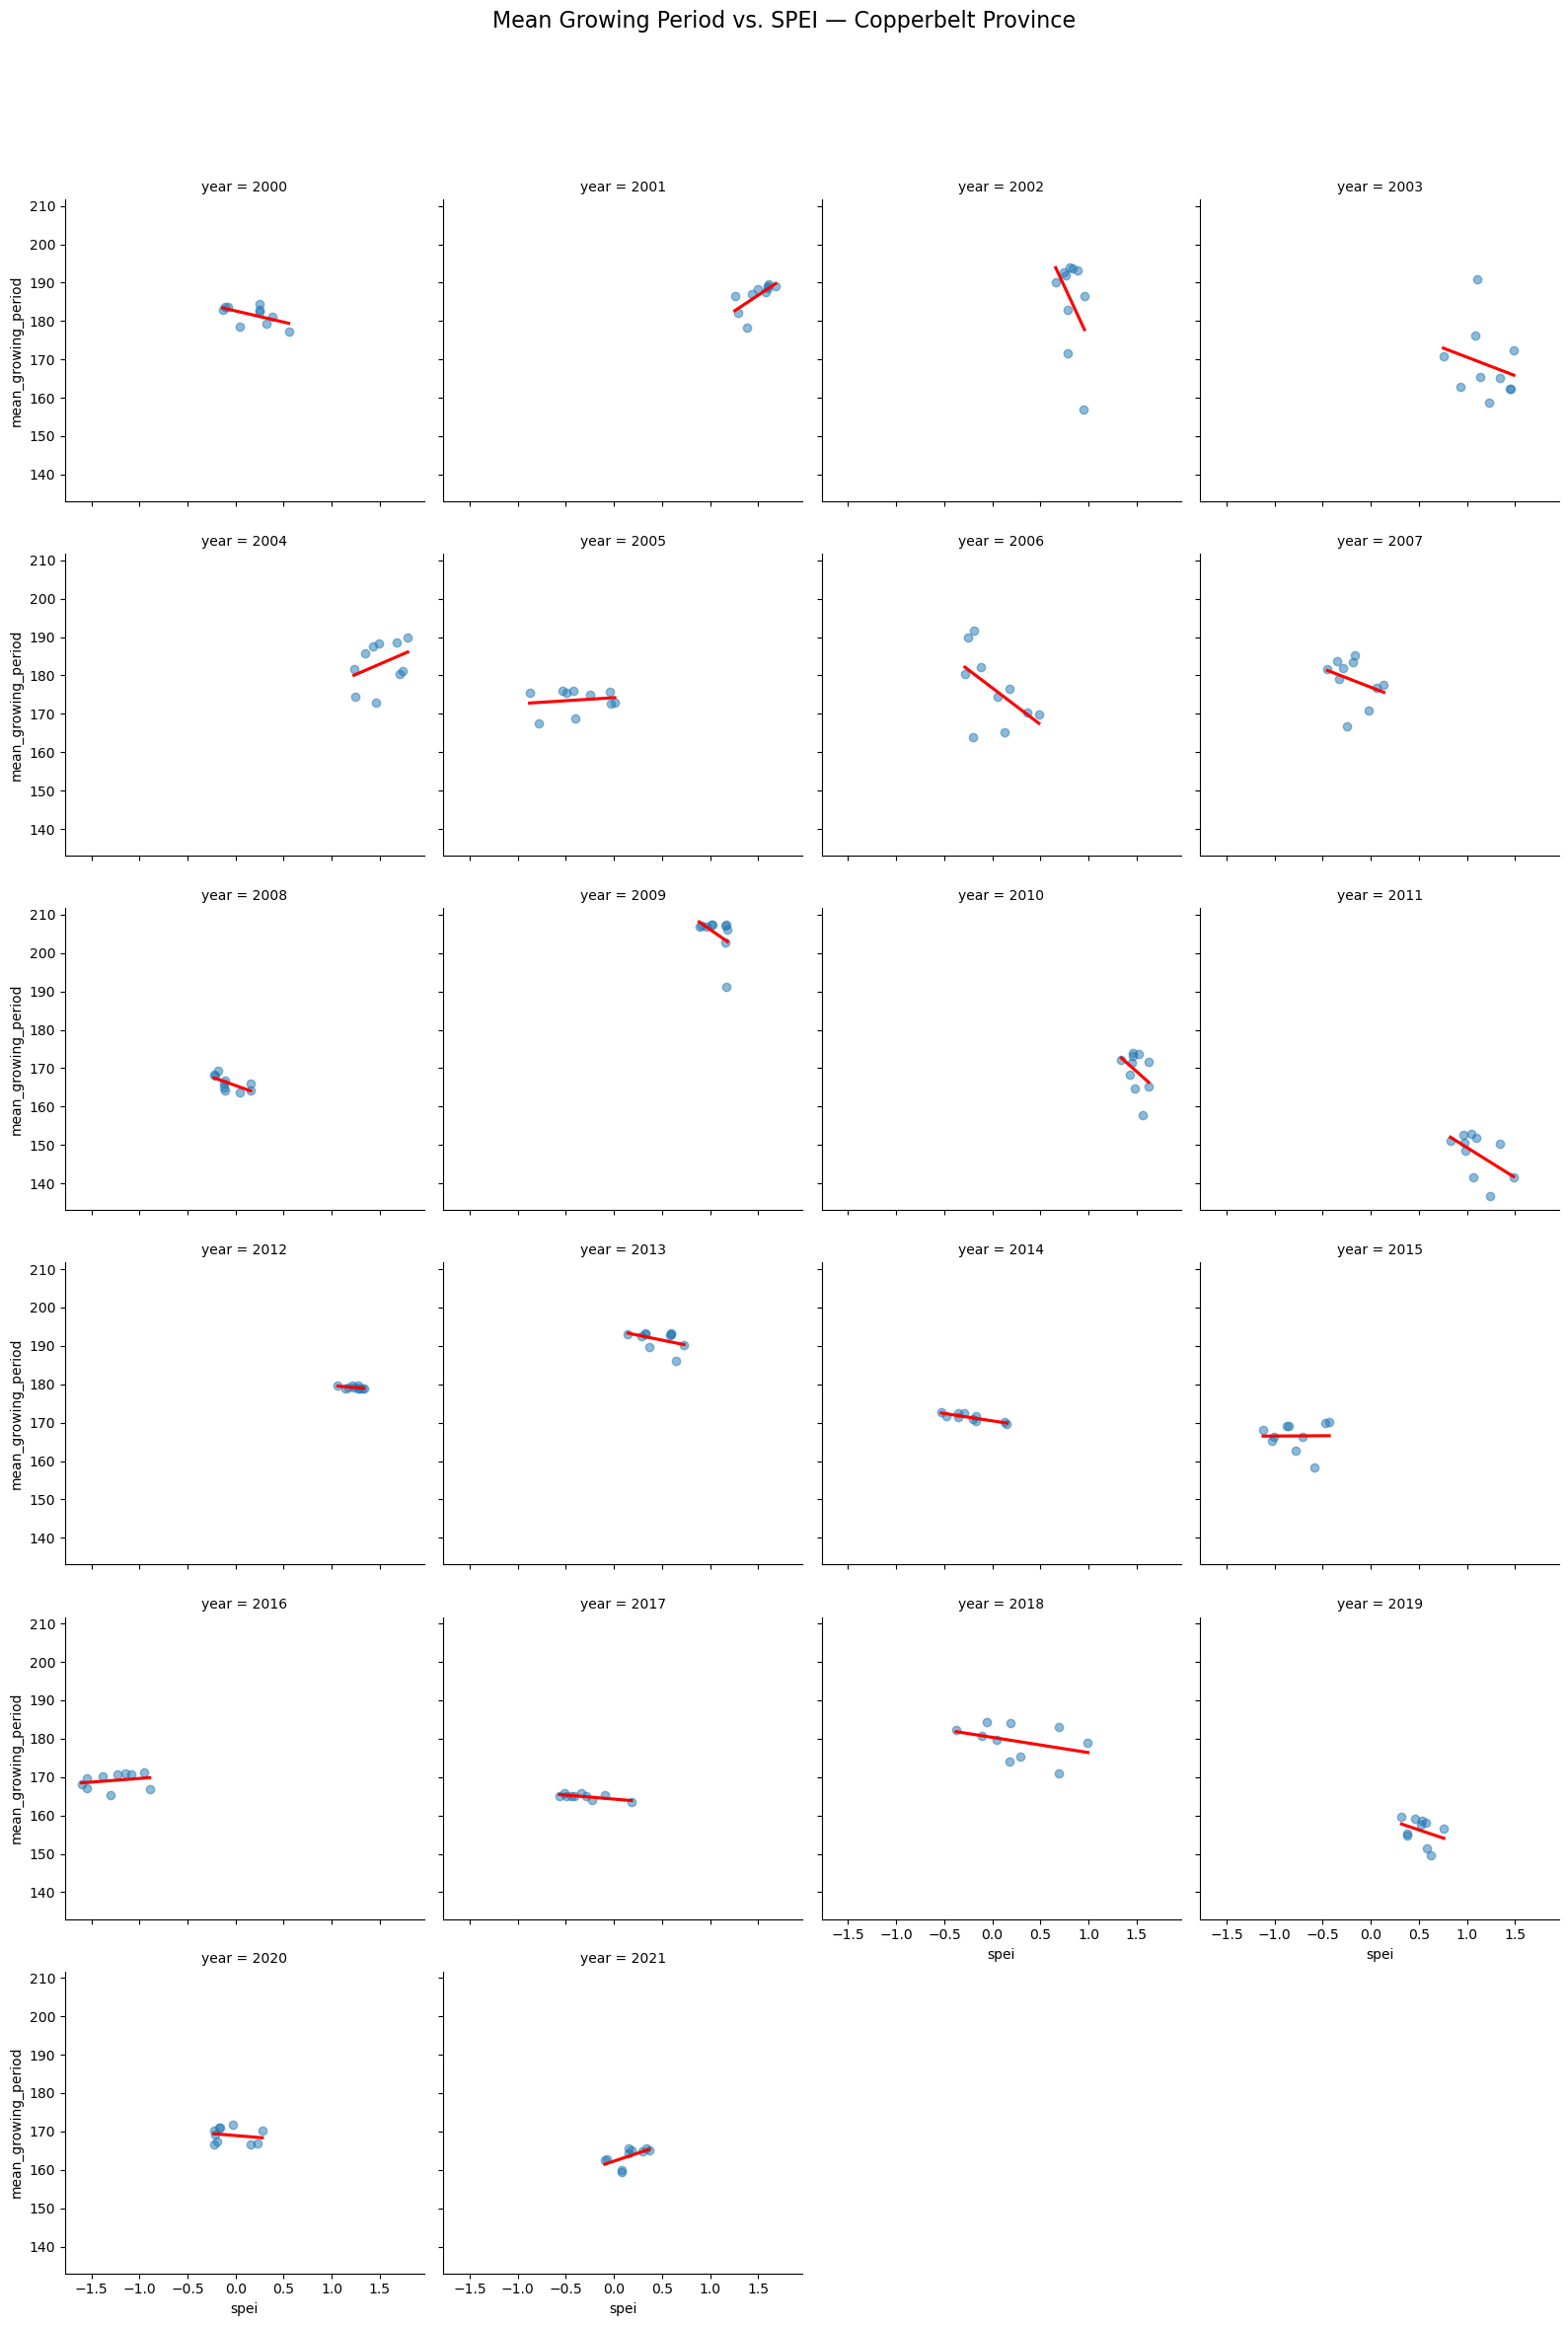

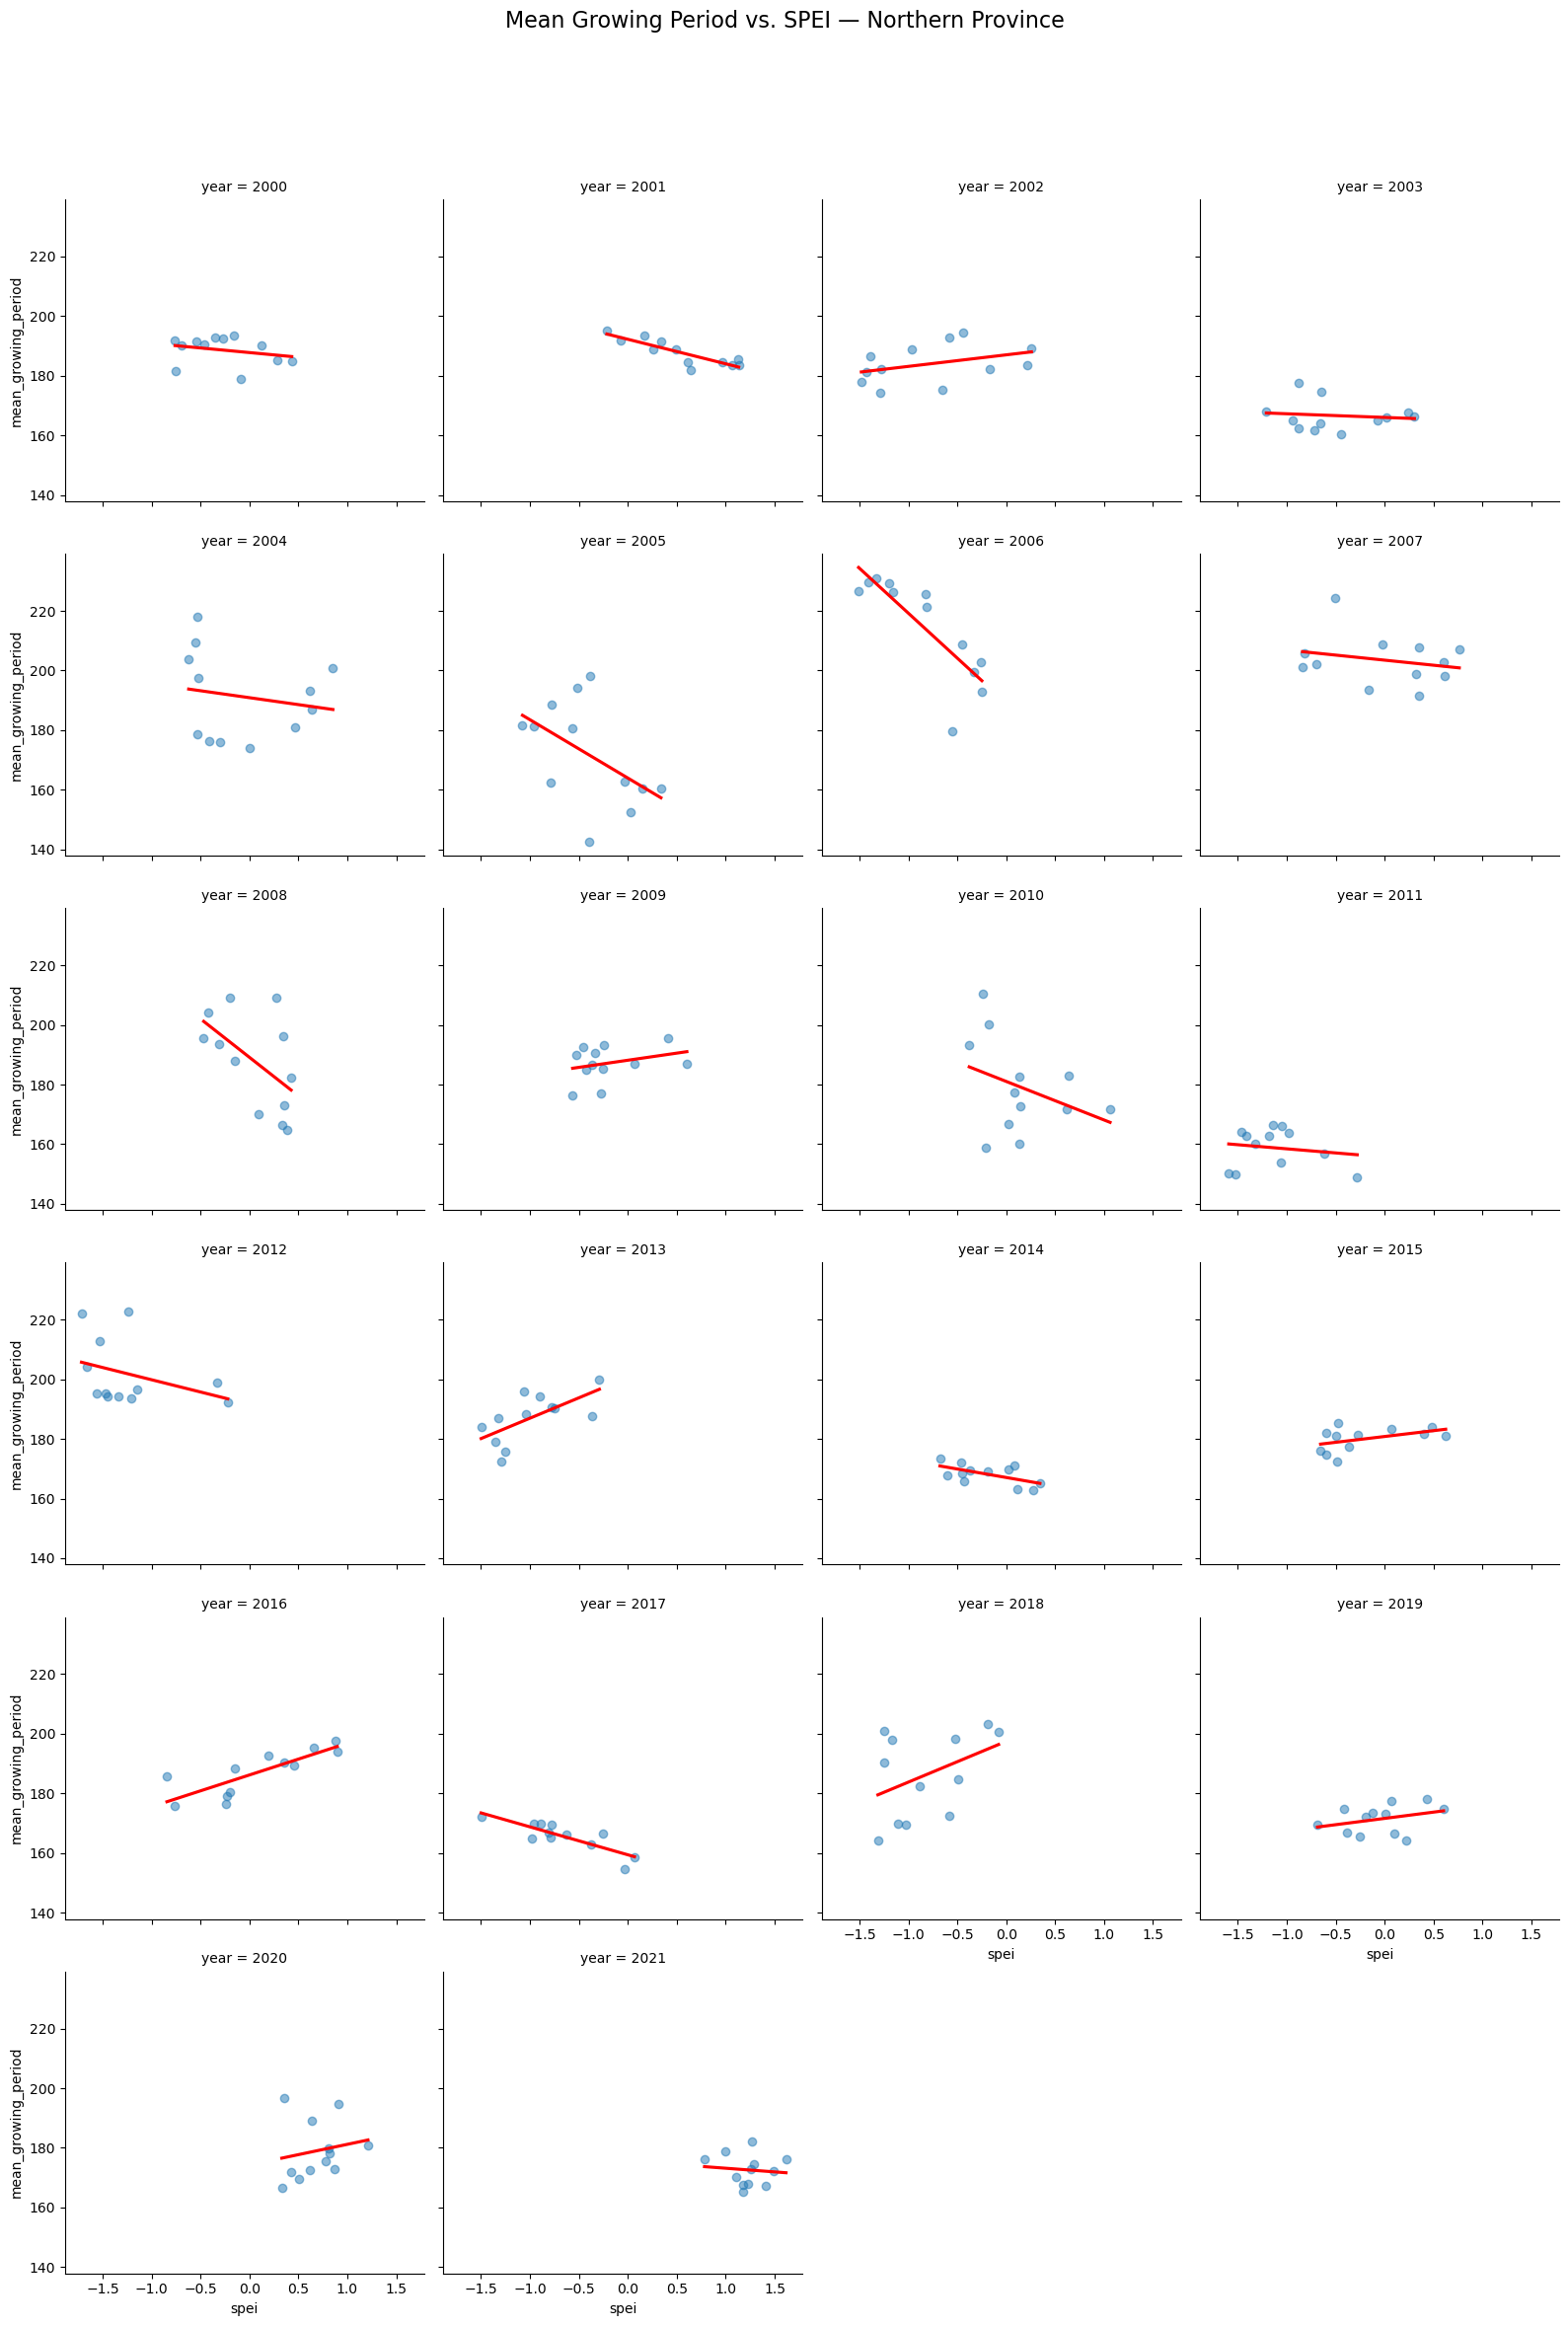

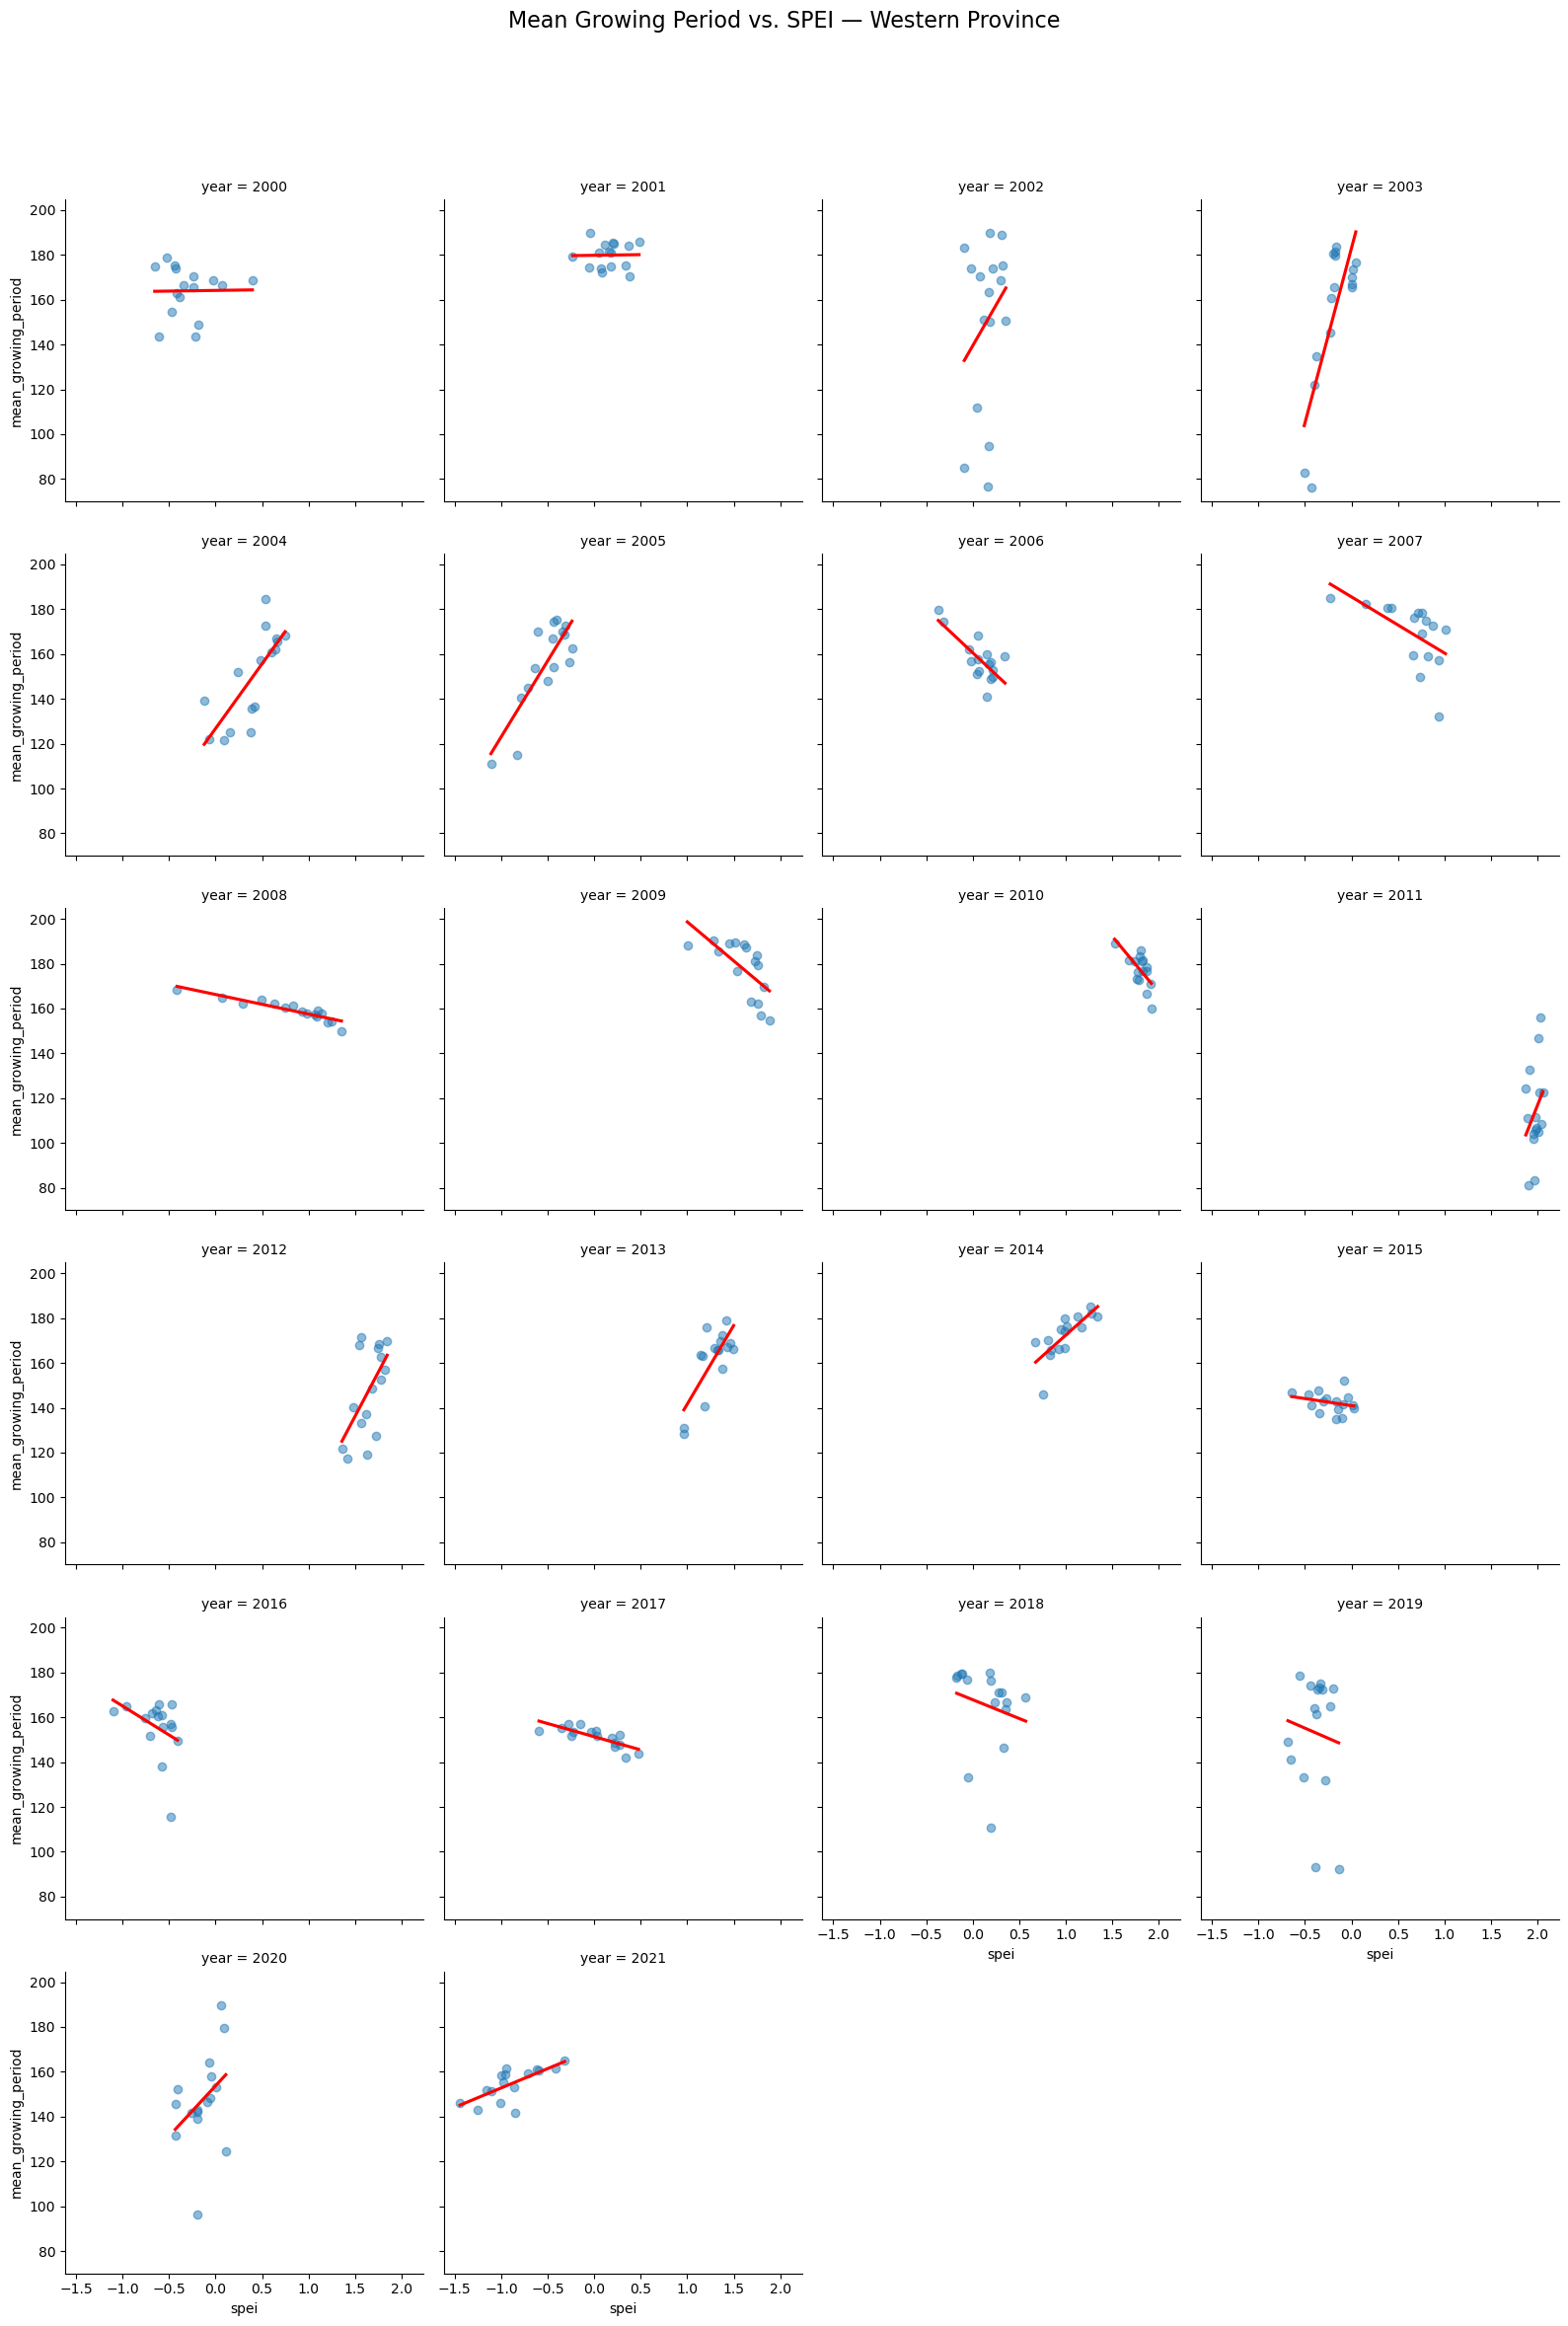

In [12]:
# loop through each province
for province in df['province'].dropna().unique():
    province_df = df[df['province'] == province]

    # faceted by year
    # linear regression line
    g = sns.lmplot(
        data=province_df,
        x='spei',
        y='mean_growing_period',
        col='year',
        col_wrap=4, 
        height=4,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'},
        ci=None
    )

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Mean Growing Period vs. SPEI — {province} Province', fontsize=16)
    plt.show()

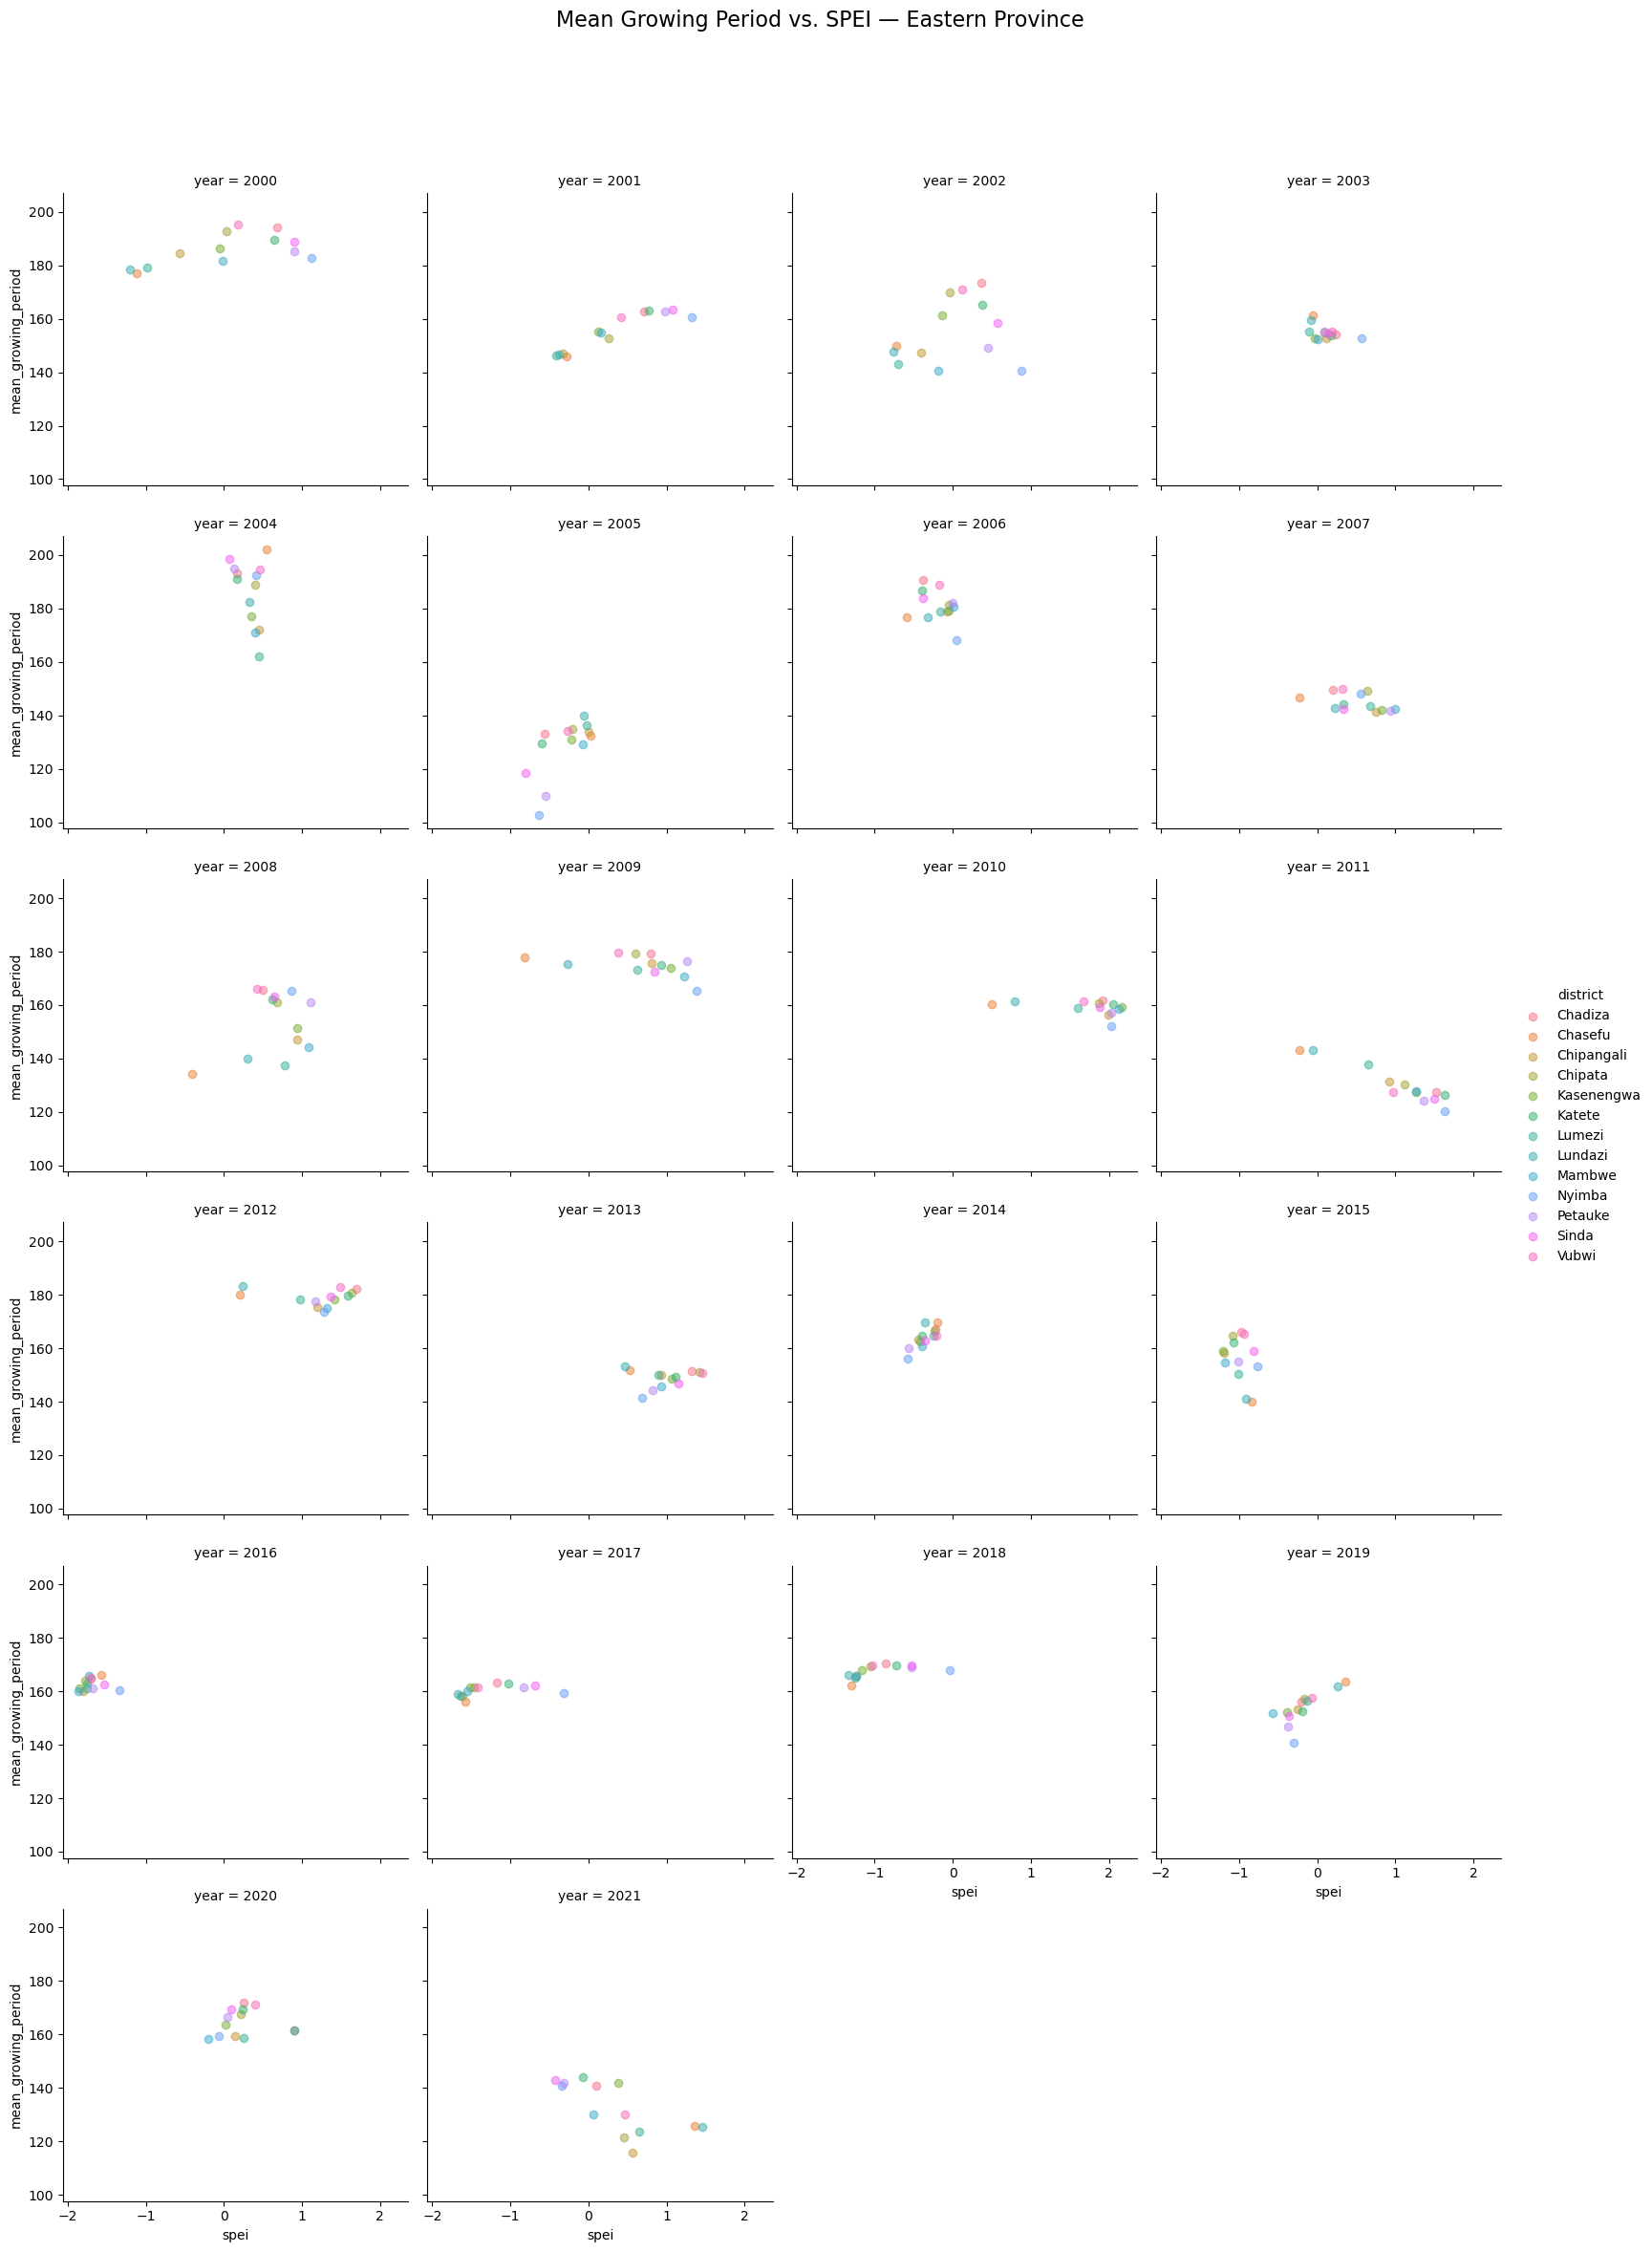

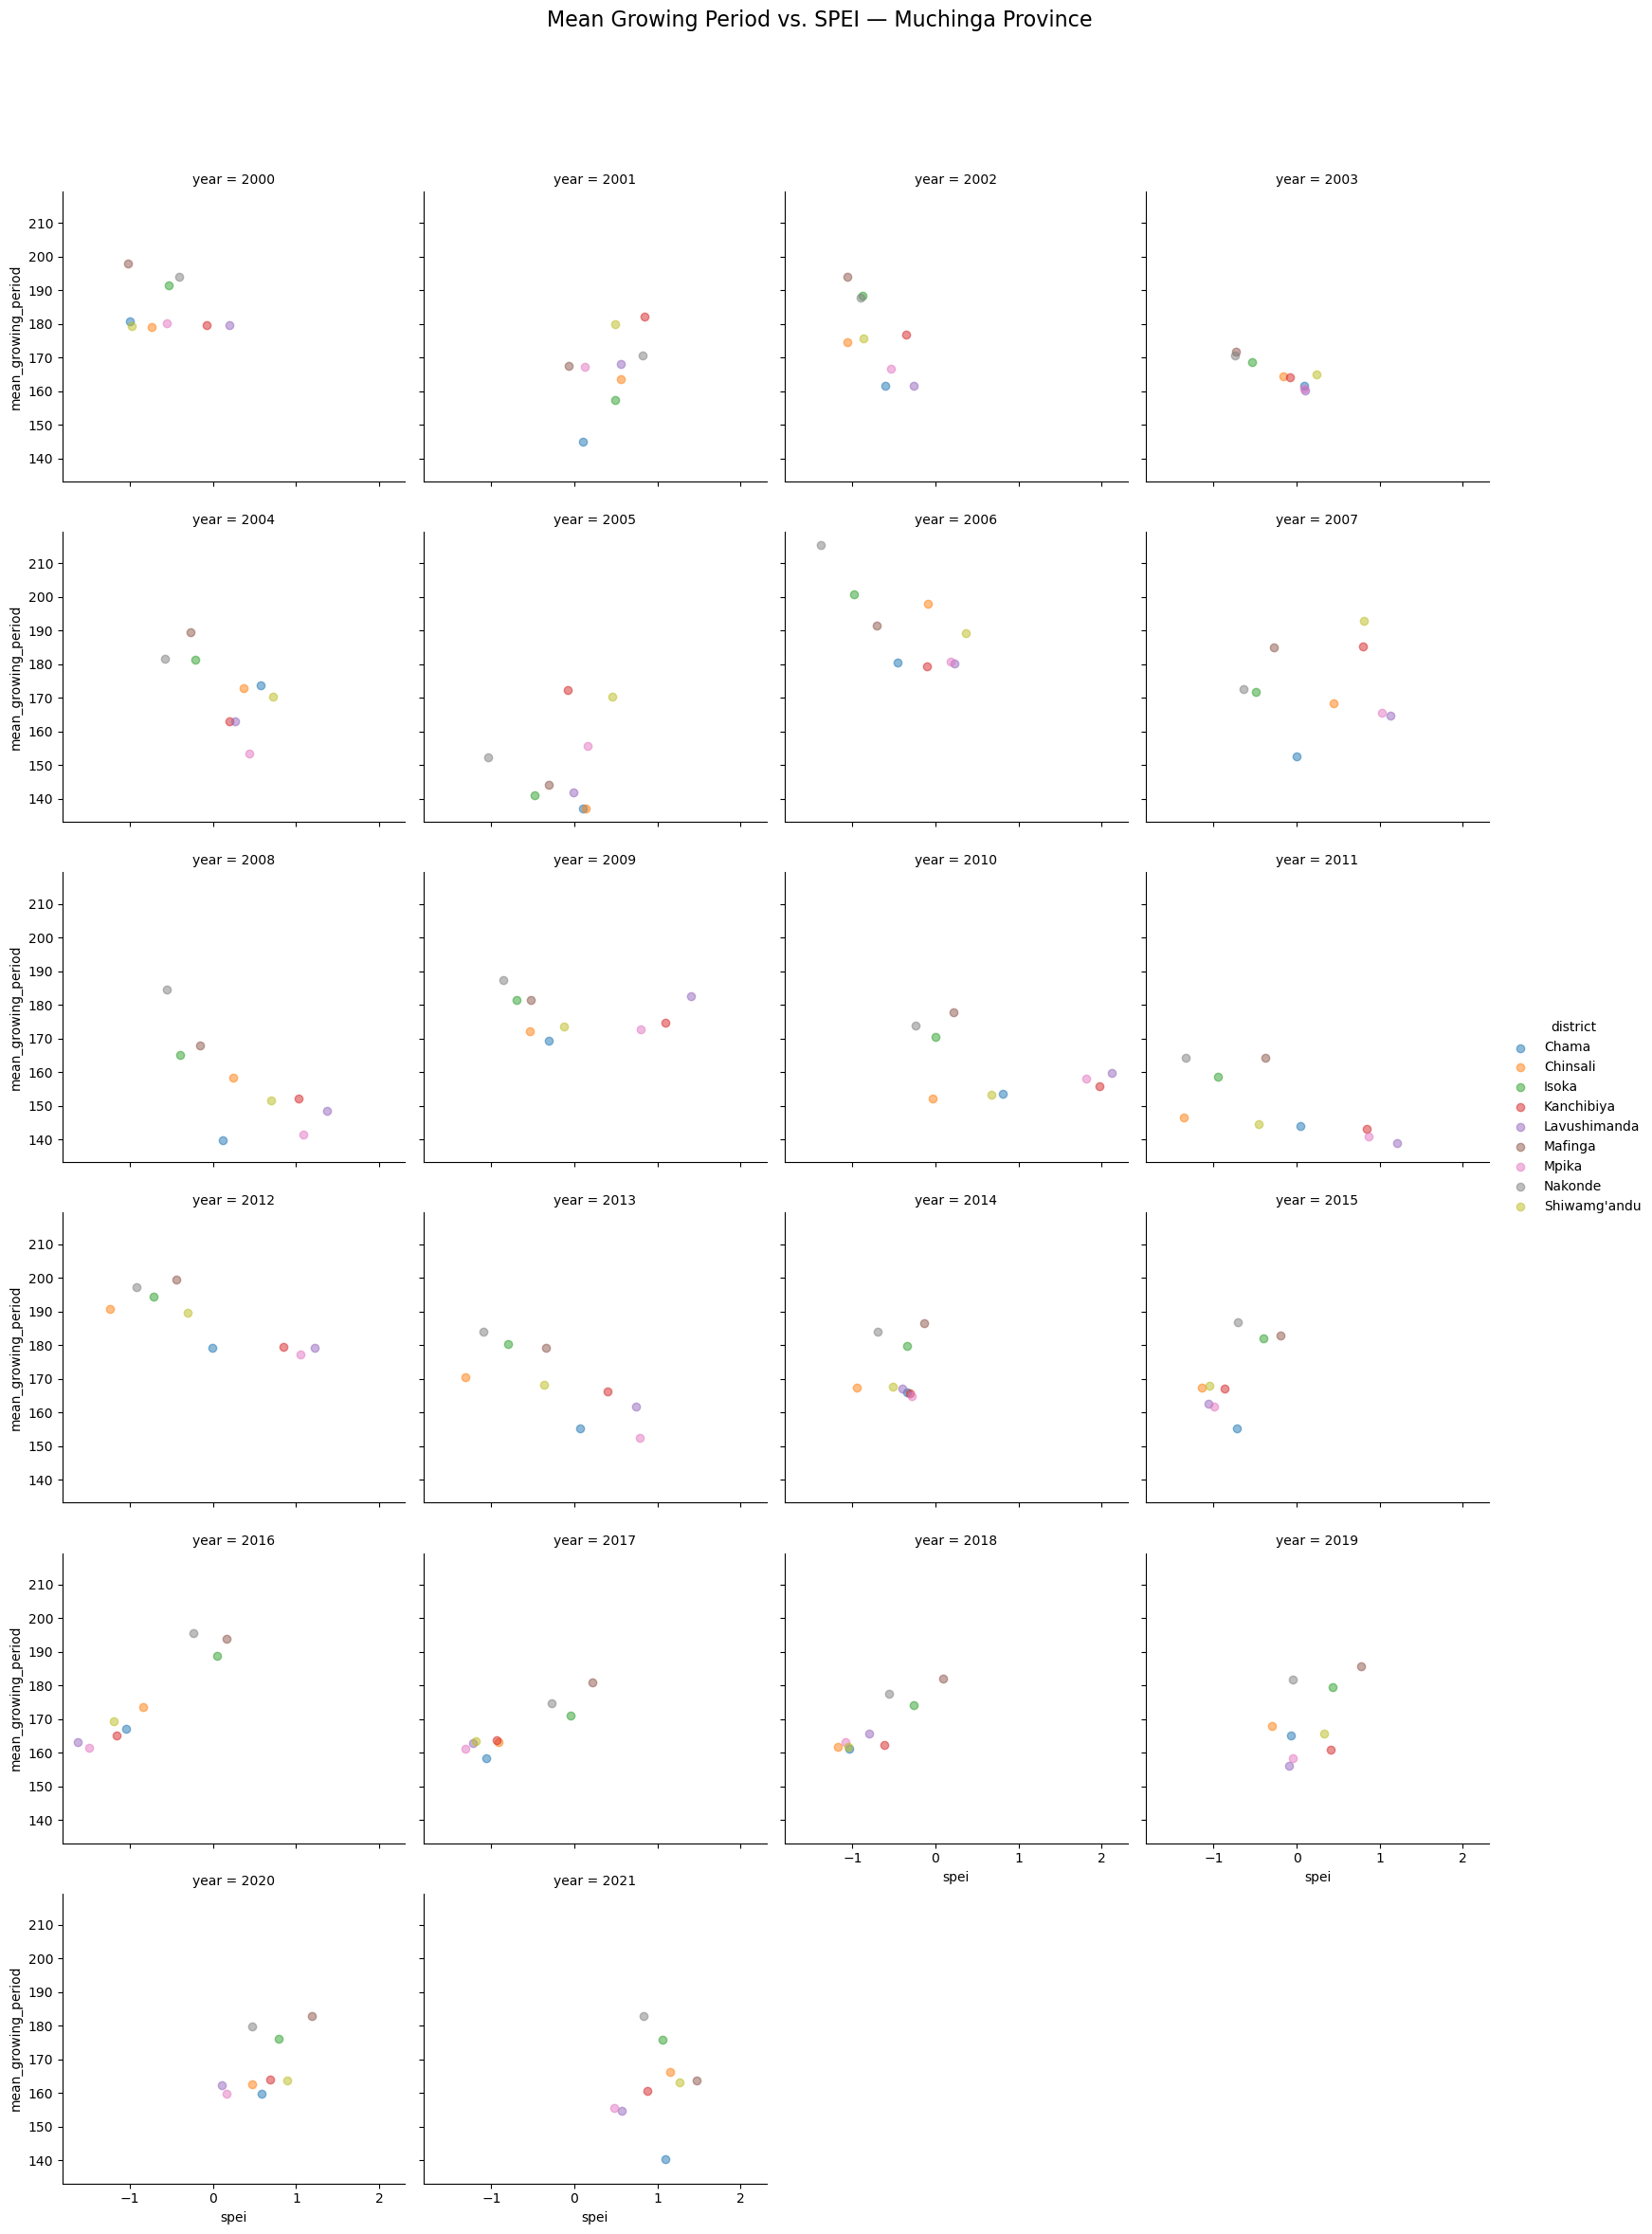

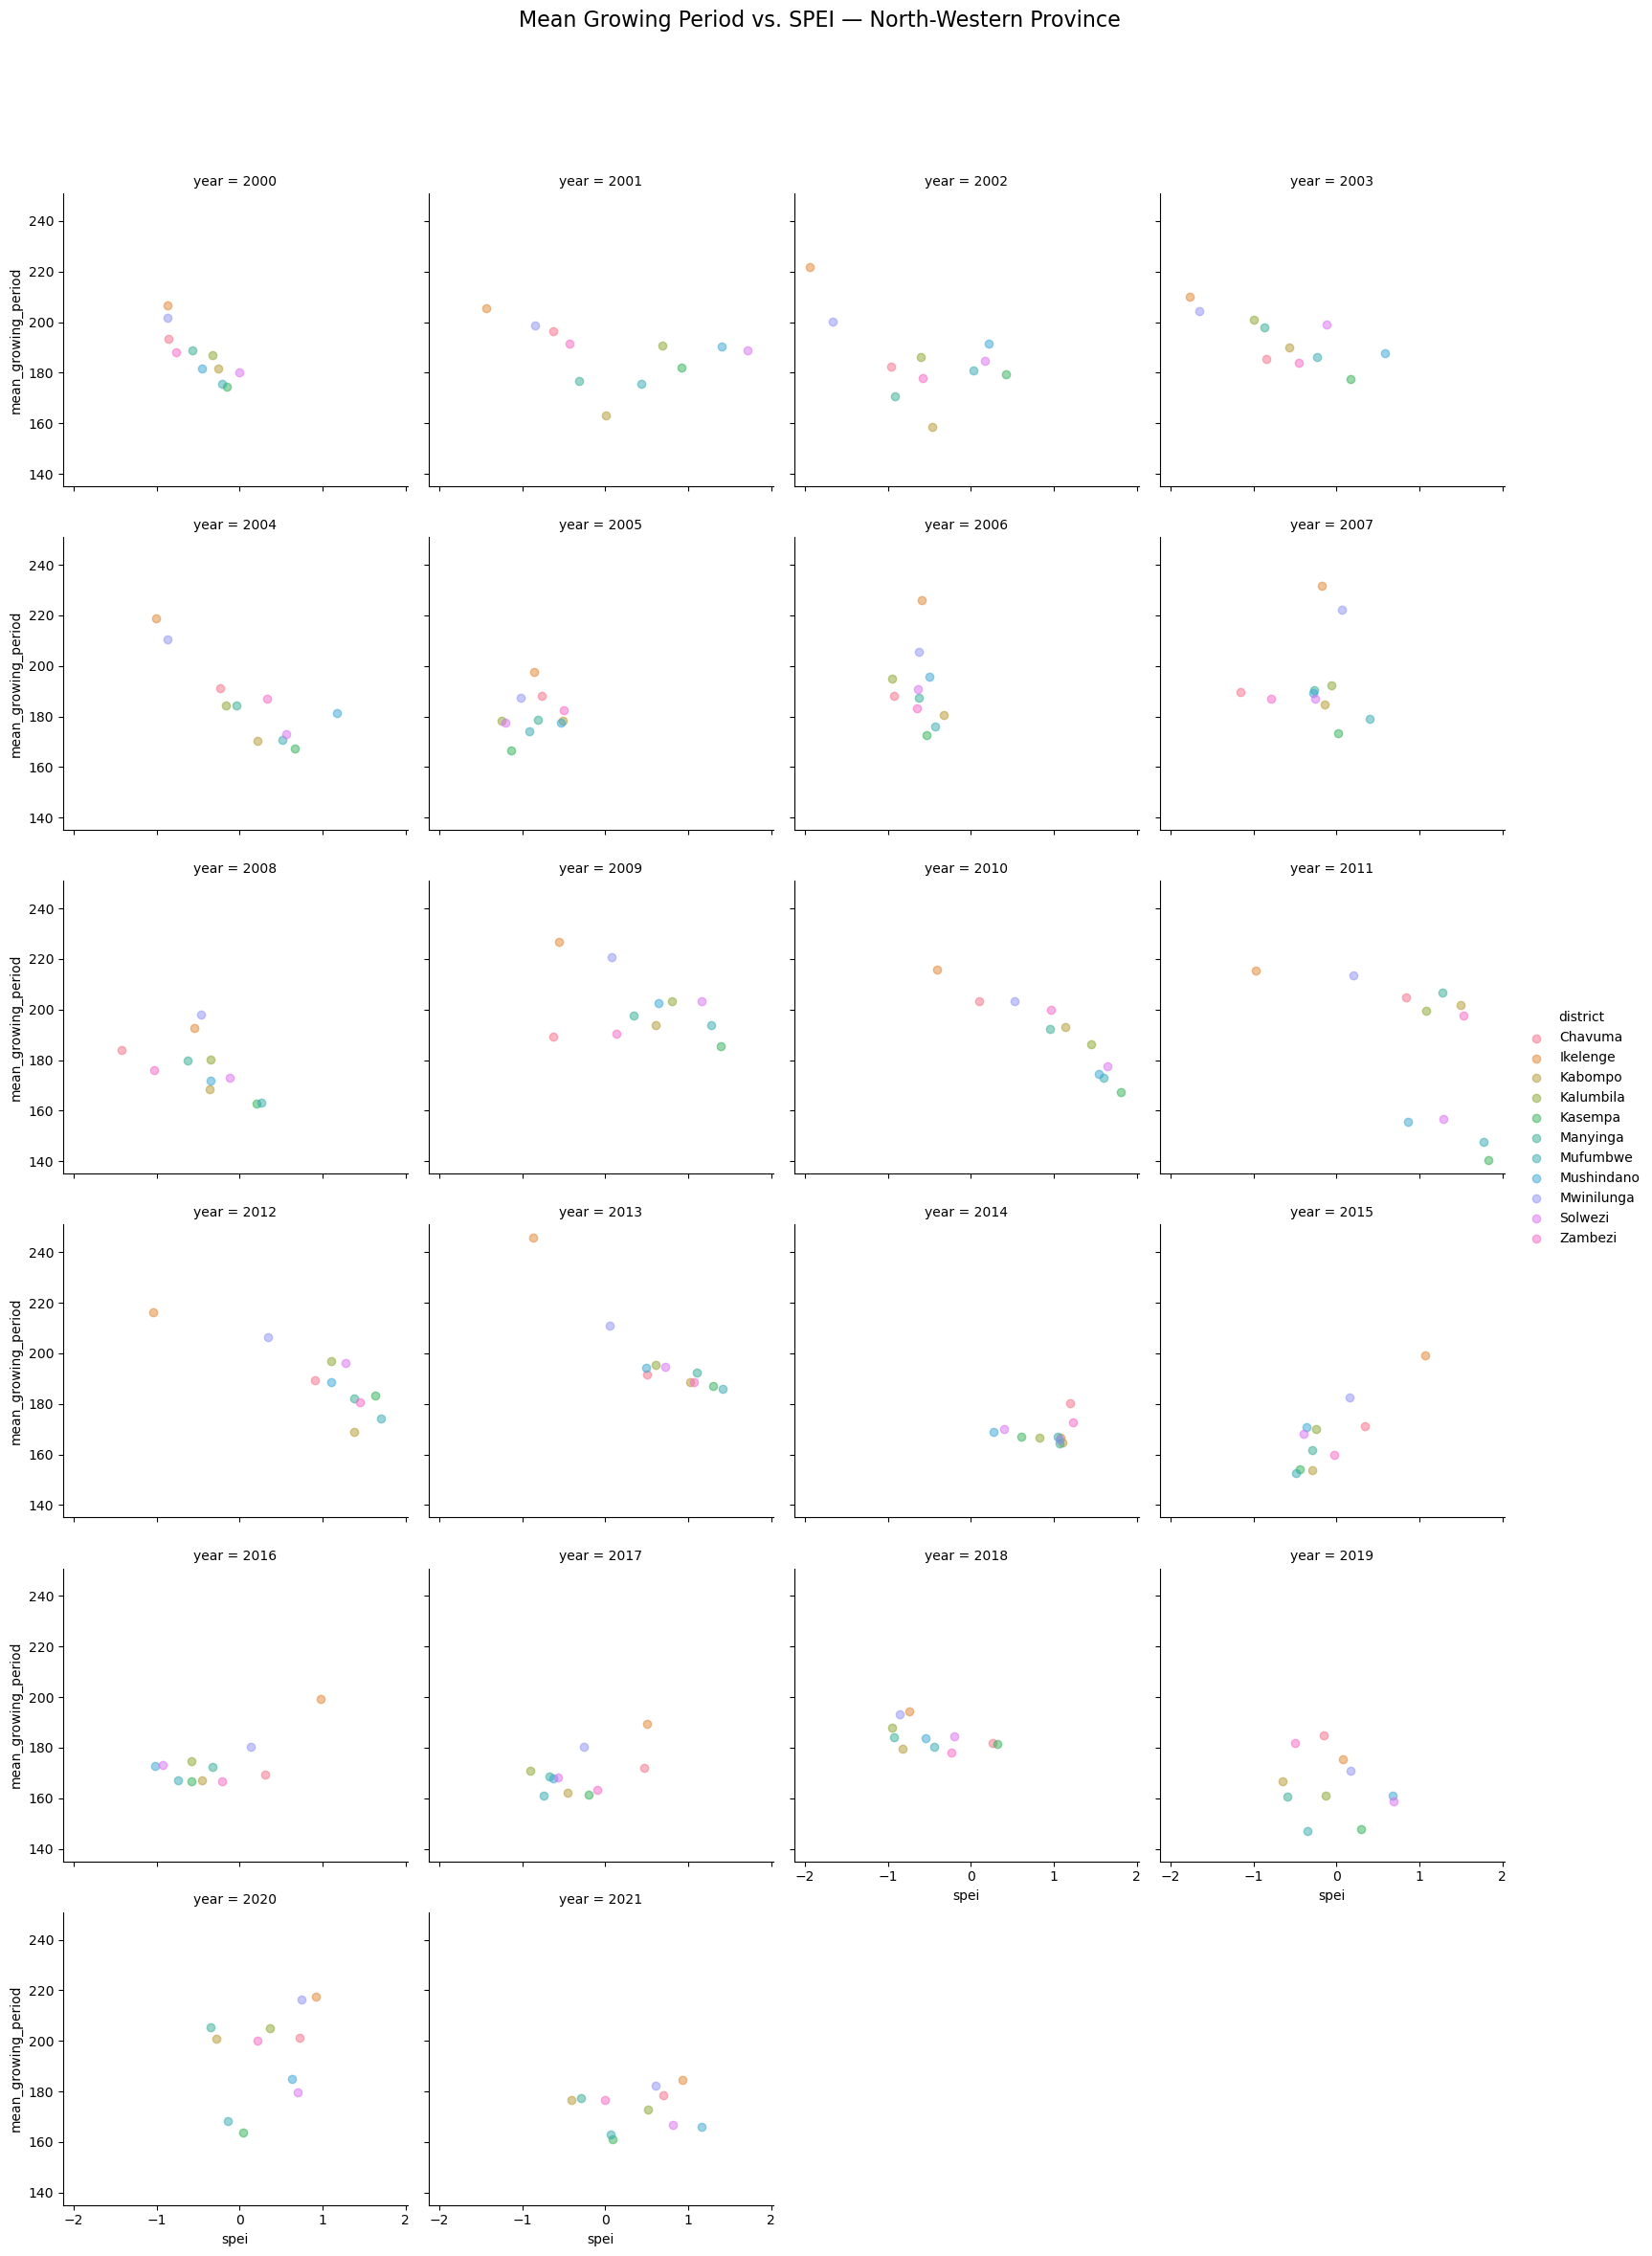

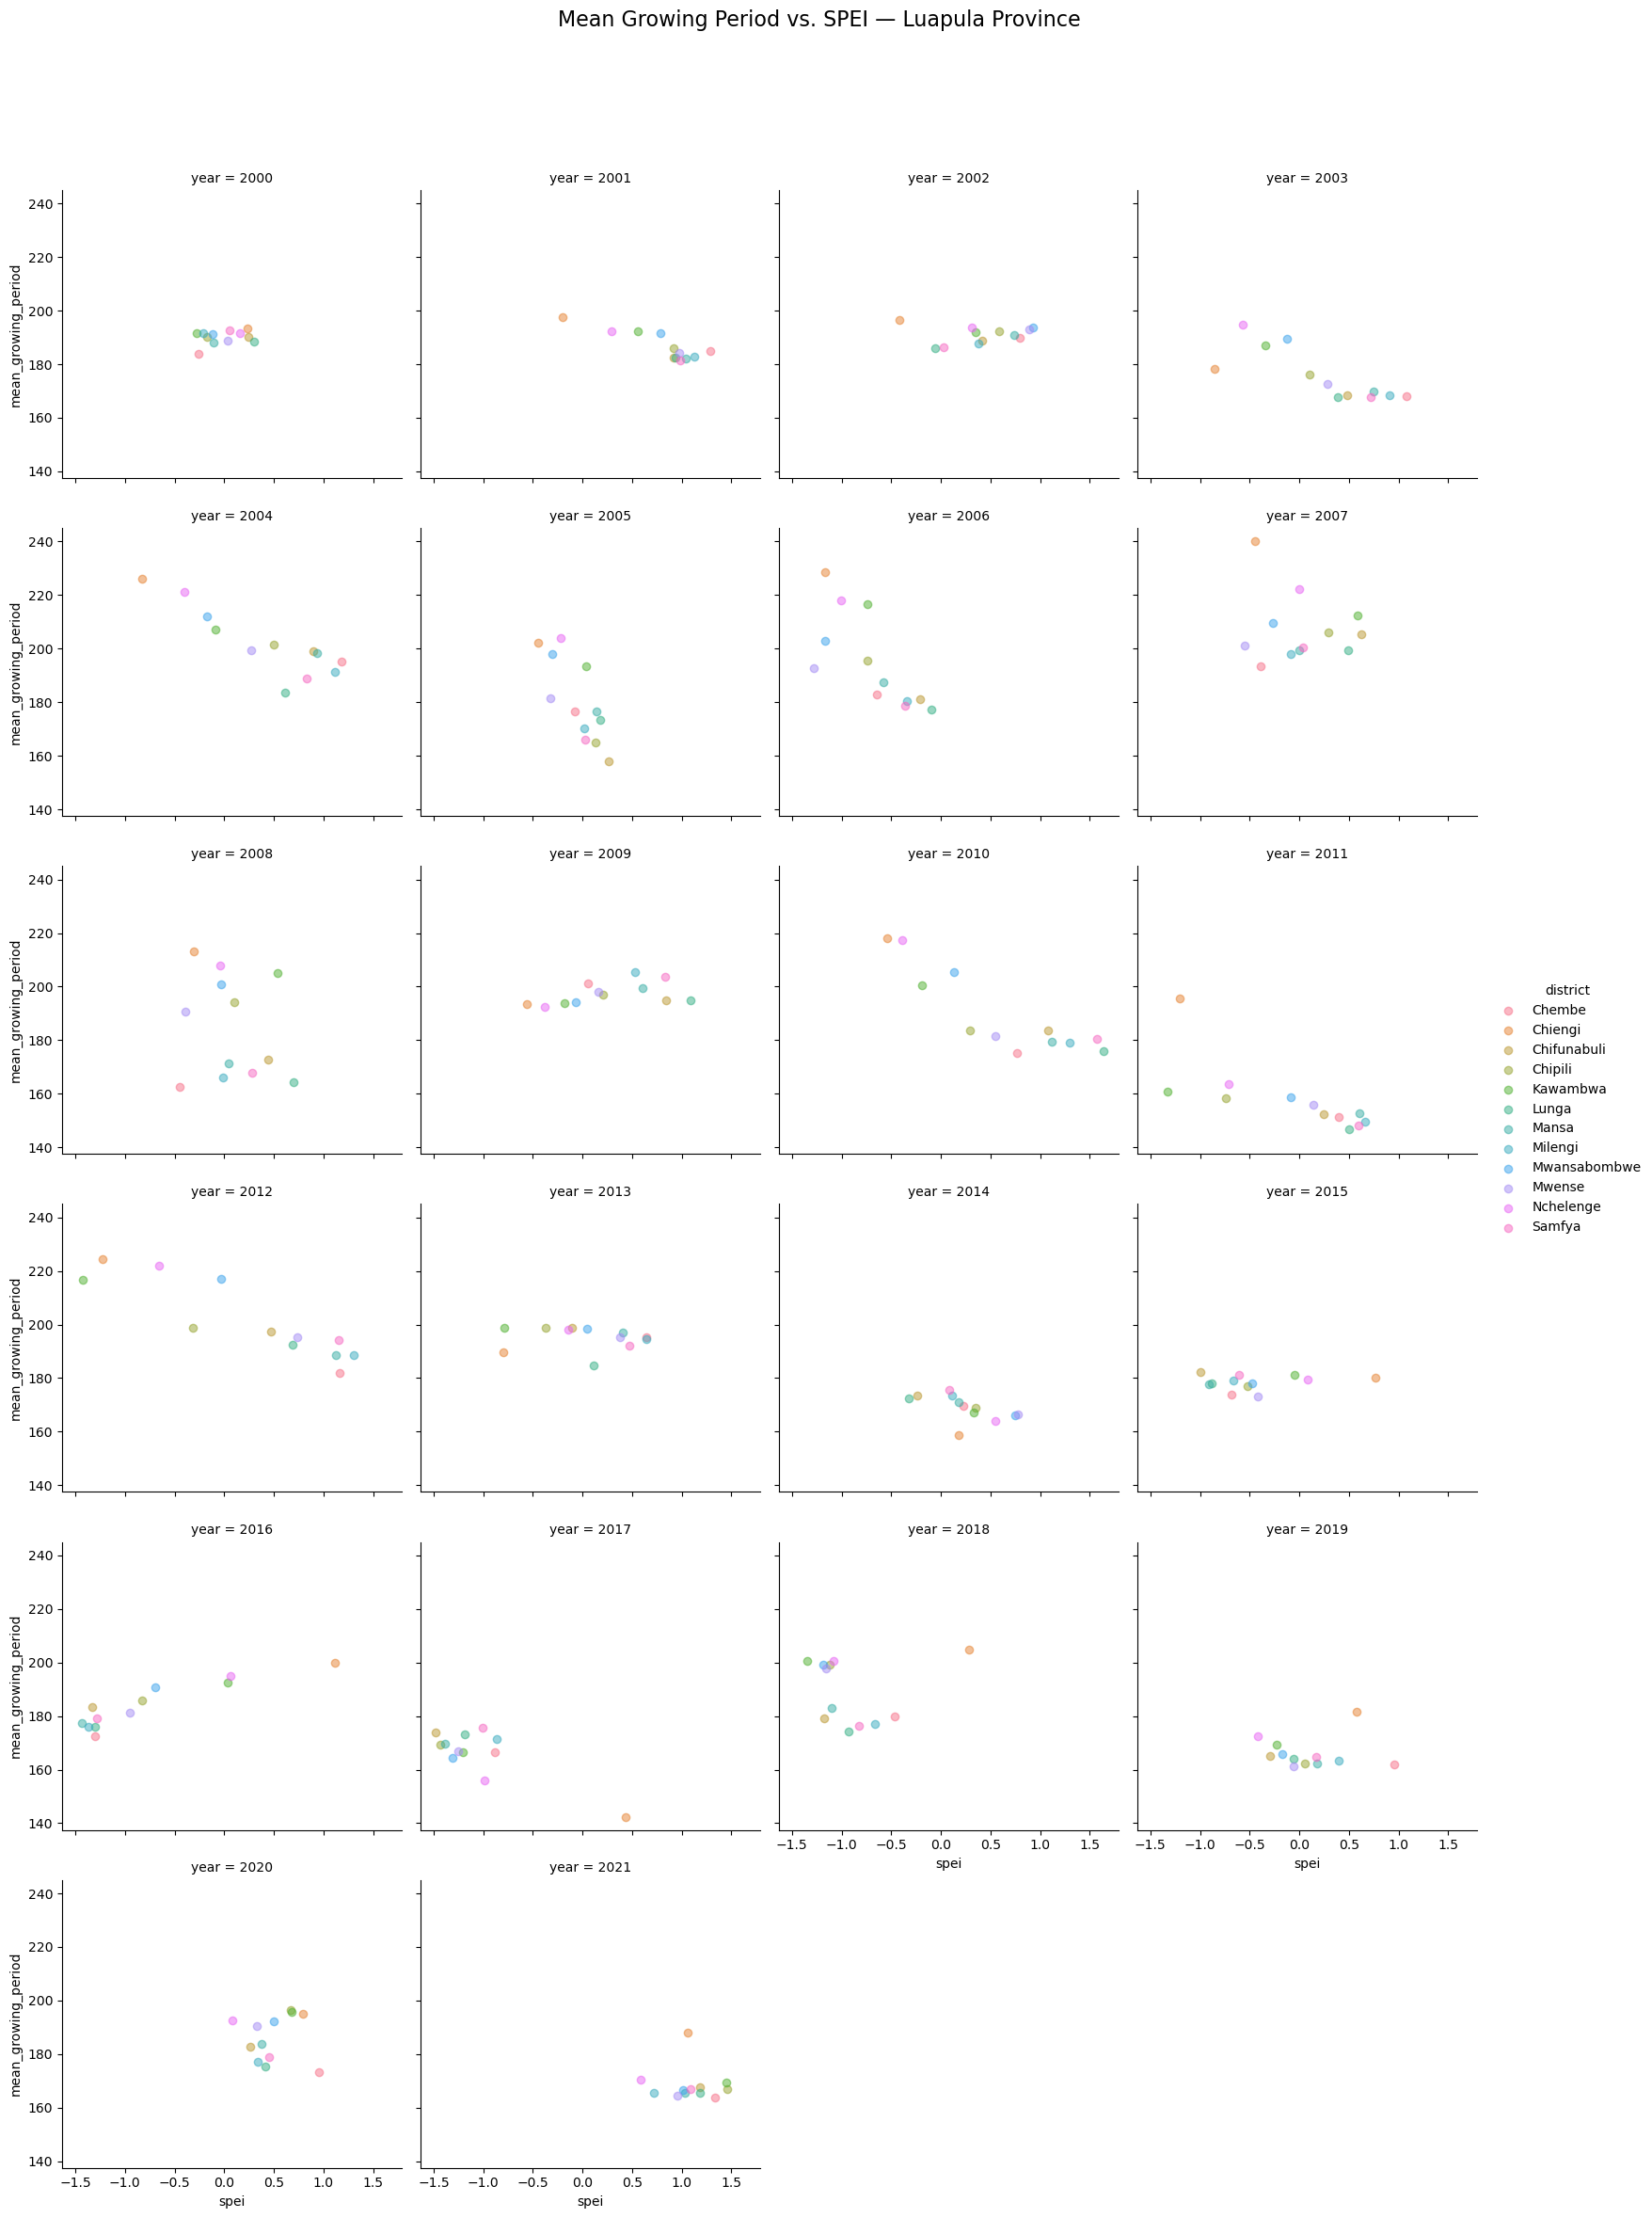

In [ ]:
# loop through each province
for province in df['province'].dropna().unique():
    province_df = df[df['province'] == province]

    # faceted by year
    # colored by district
    g = sns.lmplot(
        data=province_df,
        x='spei',
        y='mean_growing_period',
        col='year',
        hue='district',
        col_wrap=4, 
        height=4,
        scatter_kws={'alpha': 0.5},
        #line_kws={'color': 'red'},
        ci=None
    )

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Mean Growing Period vs. SPEI — {province} Province', fontsize=16)
    plt.show()

## Code graveyard

In [ ]:
# loop through provinces
for province in df['province'].dropna().unique():
    province_df = df[df['province'] == province]
    # group by year
    grouped = province_df.groupby('year')[['mean_growing_period', 'spei']].mean().reset_index()
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.scatter(grouped['year'], grouped['mean_growing_period'], color='teal', marker='o', label='Growing Period')
    ax1.set_ylabel('Mean Growing Period (days)', color='teal')
    ax1.tick_params(axis='y', color='teal')
    # create separate y-axis for SPEI
    ax2 = ax1.twinx()
    ax2.scatter(grouped['year'], grouped['spei'], color='red', marker='o', label='SPEI')
    ax2.set_ylabel('SPEI', color='red')
    ax2.tick_params(axis='y', color='red')

    plt.title(f'SPEI and Growing Period - {province} Province')
    ax1.set_xlabel('Year')
    plt.grid(True)
    plt.tight_layout()
    plt.show()